In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(font_scale=1.7)
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import math
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%store -r data_new

In [4]:
data_new.shape

(41772, 74)

In [5]:
col = data_new.columns.tolist()
na_count = data_new.isnull().sum()

In [6]:
col_null = na_count.index[na_count.values>0]

In [7]:
data_new[col_null] = data_new[col_null].fillna(0)

In [8]:
from sklearn.model_selection import train_test_split

X = data_new.ix[:, 1:]
y = data_new.ix[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train = X_train.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)

In [9]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10)

In [10]:
col = pd.Series(data_new.columns)

## Baseline Model

In [25]:
def RMSPE(y, y_pred):
    return math.sqrt( ((1- y_pred / y)**2).mean() )

In [112]:
bl_price = pd.concat((X_train, y_train), axis = 1).groupby(
    ['neighbourhood_cleansed', 'room_type'])['Total_Price'].mean().reset_index(drop = False)

In [113]:
bl_price.head()

,neighbourhood_cleansed,room_type,Total_Price
0,Barking and Dagenham,Entire home/apt,80.111111
1,Barking and Dagenham,Private room,41.068182
2,Barking and Dagenham,Shared room,25.000000
3,Barnet,Entire home/apt,130.820513
4,Barnet,Private room,47.917379


In [114]:
X_test = pd.merge(X_test, bl_price, on = ['neighbourhood_cleansed', 'room_type'], how = 'left')

In [115]:
y_test = y_test.reset_index(drop = True)

In [116]:
RMSPE(y_test , X_test['Total_Price'])

0.5448207944180434

### Drop unnecessary columns in X_train and X_test

In [16]:
X_train = X_train.ix[:,:-2]
X_test = X_test.ix[:,:-2]

In [17]:
X_train.head()

,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,3,1.0,0.0,1.0,2,1,40.0,4.0,4.0,10.0,...,0,0,1,0,0,0,0,0,0,1
1,1,3.0,1.0,1.0,2,4,95.0,10.0,10.0,10.0,...,0,0,0,1,0,0,0,0,0,1
2,4,1.0,2.0,1.0,1,2,100.0,10.0,10.0,10.0,...,0,0,1,0,0,0,0,0,0,1
3,4,2.0,2.0,2.0,1,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
4,1,1.5,1.0,1.0,1,237,96.0,10.0,10.0,10.0,...,0,0,0,1,0,0,0,0,0,1


### Linear Regression

In [30]:
y_test.describe()

count    8355.000000
mean      105.455536
std        73.265158
min         7.000000
25%        50.000000
50%        85.000000
75%       140.000000
max       400.000000
Name: Total_Price, dtype: float64

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
%%time
lr = LinearRegression()
score = []
for train_idx, test_idx in kf.split(X_train.values):
    X_train_val, y_train_val = X_train.values[train_idx], y_train.values[train_idx]
    X_test_val, y_test_val = X_train.values[test_idx], y_train.values[test_idx]
    mse =RMSPE(y_test_val , lr.fit(X_train_val, y_train_val).predict(X_test_val))
    score.append(mse)

CPU times: user 2.01 s, sys: 239 ms, total: 2.25 s
Wall time: 1.31 s


In [33]:
score

[1.212051151986784,
 4.376754179989392,
 1.7639240998461607,
 1.3772456624956724,
 3.874488942687747,
 1.952758785652749,
 0.9148586405198202,
 1.117335993057832,
 10.389873823784335,
 2.2572649170482073]

- Forward Stepwise Variable Selection

In [177]:
y = ['Total_Price']
x = []
n = X_train.shape[0]
q = 1

In [178]:
%%time

for i in range(X_train.shape[1]):
    ## Prepare data for later use
    Y_ols = y_train # Y for OLS
    X_ols = sm.add_constant(X_train[x]) # X for OLS
    p = len(x) 
    model0 = sm.OLS(Y_ols, X_ols).fit() 
    ssres0 = model0.ssr  # Get the original ssr
    var_in_model = x.copy() # Get a list of variables already in the original OLS
    score = []             # Define an empty list to store F-scores
    
    ## Start the variable selection
    for var in X_train.drop(var_in_model, axis = 1).columns: # Get rid of the variables already in the original OLS
        X_ols_plus = pd.concat([X_ols, X_train[var]], axis = 1)  # Construct new X by adding a new variable
        model1 = sm.OLS(Y_ols, X_ols_plus).fit() 
        ssres1 = model1.ssr
        F = (ssres0-ssres1)/q/(ssres1/(n-p-q-1)) # Calculate the F-value
        score.append([var, F]) # Store the variable and its F-value in a list
    highest_F = sorted(score, key = lambda x:x[1], reverse = True)[0] # Find the highest F-value
    if highest_F[1] > 2.07:  ## Maybe change the threshold here
        x.append(highest_F[0])
    else:
        break

CPU times: user 3min 39s, sys: 43.5 s, total: 4min 23s
Wall time: 2min 25s


In [179]:
model_vs = sm.OLS(y_train, sm.add_constant(X_train[x])).fit()

In [180]:
RMSPE(y_test, model_vs.predict(sm.add_constant(X_test[x])))

## Model performance is the same as non variable selection model

9.742723270450698

In [270]:
model_vs.summary();

### Regularized Linear Models
- https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models/comments

In [38]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score

#### Lasso

In [39]:
%%time
alphas = [0.05, 0.1, 0.3, 1, 2, 3, 5, 10]
scores_lasso = []
kf = KFold(n_splits=10, random_state = 123)

for alpha in alphas:
    lasso = Lasso(alpha)
    for train, val in kf.split(X_train):
        score_cv = []
        y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
        score_cv.append(RMSPE(y_train.values[val], y_pred))
        score = np.mean(score_cv)
    scores_lasso.append(score)

CPU times: user 3min 3s, sys: 4.14 s, total: 3min 7s
Wall time: 1min 41s


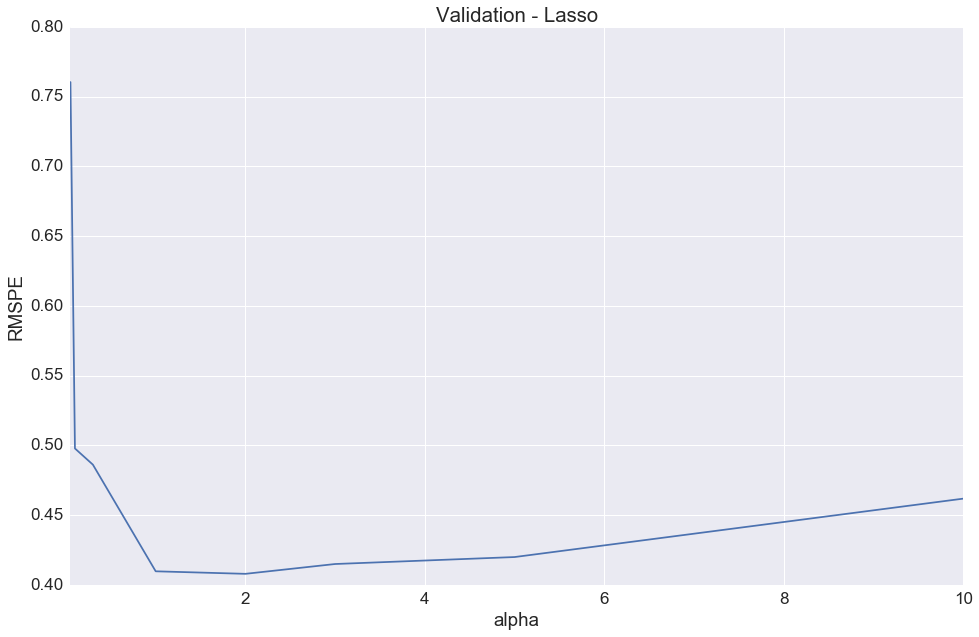

In [40]:
plt.figure(figsize=(16,10))
cv_lasso = pd.Series(scores_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("RMSPE")

In [41]:
cv_lasso.argmin()

2.0

In [42]:
%%time
alphas = [  0.5,  1 , 1.5, 1.75, 2.0, 2.25, 2.5, 3.0]
scores_lasso = []
kf = KFold(n_splits=10, random_state = 123)

for alpha in alphas:
    lasso = Lasso(alpha)
    for train, val in kf.split(X_train):
        score_cv = []
        y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
        score_cv.append(RMSPE(y_train.values[val], y_pred))
        score = np.mean(score_cv)
    scores_lasso.append(score)

CPU times: user 1min 47s, sys: 3.62 s, total: 1min 51s
Wall time: 1min 3s


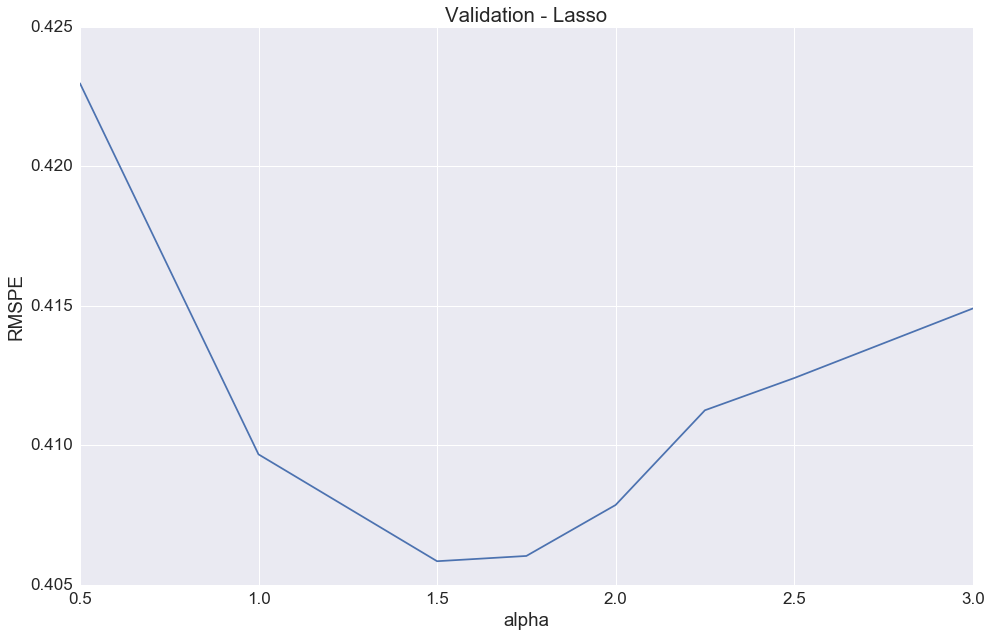

In [43]:
plt.figure(figsize=(16,10))
cv_lasso = pd.Series(scores_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("RMSPE")

In [44]:
cv_lasso.argmin()

1.5

In [45]:
lasso = Lasso(alpha=1.5)

In [46]:
%%time
scores_lasso = []
kf = KFold(n_splits=10, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_lasso.append(score)

CPU times: user 7.97 s, sys: 295 ms, total: 8.27 s
Wall time: 4.53 s


In [47]:
scores_lasso

[0.41720648407125527,
 0.41296163566906446,
 0.4237506742355229,
 0.40144454346204356,
 0.3950447023393609,
 0.4346220928894885,
 0.4456894514851618,
 0.3881946184677136,
 0.4148112308134466,
 0.40584534224908364]

In [61]:
len(lasso.coef_)

71

In [72]:
lasso_variable = pd.DataFrame({'variable':data_new.columns.tolist()[1:-2], 'coef':lasso.coef_})
lasso_intercept = pd.DataFrame({'variable':'constant', 'coef':lasso.intercept_}, index = range(1))
lasso_func = pd.concat((lasso_intercept, lasso_variable), axis = 0).reset_index(drop = 1)
lasso_func[lasso_func['coef']!=0]

,coef,variable
0,34.768697,constant
1,9.819306,accommodates
2,4.208943,bathrooms
3,21.159074,bedrooms
6,-0.059417,number_of_reviews
10,-1.255246,review_scores_checkin
11,-1.112859,review_scores_communication
12,3.070839,review_scores_location
13,-1.896903,review_scores_value
14,-0.624785,reviews_per_month


### Plot Error Distirbution of Lasso

## ensemble - RandomForestRegressor
- https://www.kaggle.com/dfitzgerald3/house-prices-advanced-regression-techniques/randomforestregressor/comments

In [133]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
kf = KFold(n_splits=10, random_state = 123)

In [48]:
%%time
scores = []

clf = RandomForestRegressor(n_estimators=50, n_jobs=-1)
for train, val in kf.split(X_train):
    y_pred = clf.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores.append(score)

CPU times: user 3min 47s, sys: 3.8 s, total: 3min 51s
Wall time: 1min 12s


In [49]:
scores
np.mean(scores)

0.37979904589846336

CPU times: user 118 ms, sys: 7.61 ms, total: 126 ms
Wall time: 142 ms


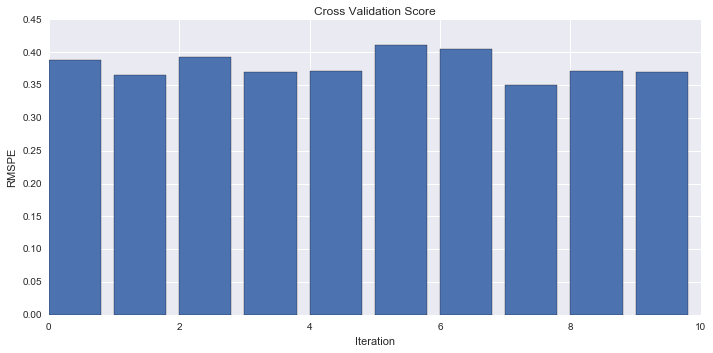

In [50]:
%%time
plt.figure(figsize=(10,5))
plt.bar(range(len(scores)), scores)
plt.title('Cross Validation Score')
plt.ylabel('RMSPE')
plt.xlabel('Iteration')

plt.tight_layout()

CPU times: user 28.7 s, sys: 521 ms, total: 29.2 s
Wall time: 9.37 s


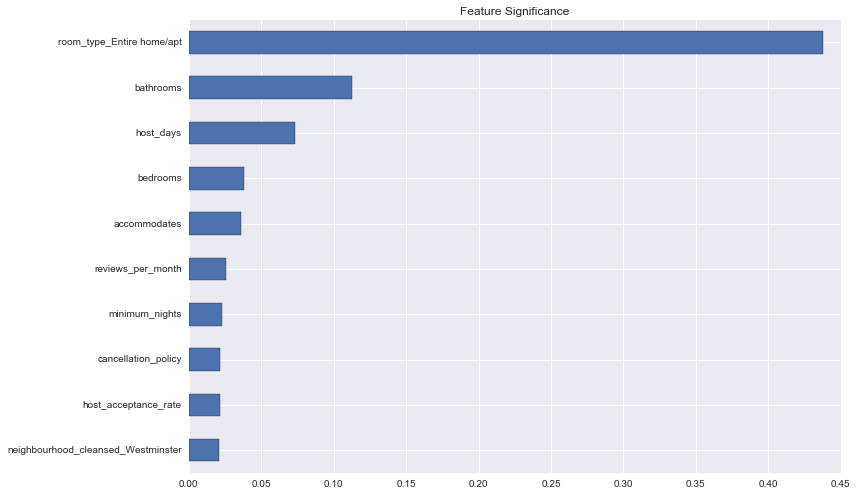

In [52]:
%%time
clf.fit(X_train, y_train)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False)

plt.figure(figsize=(12, 7))
coef[:10].sort_values(ascending = True).plot(kind = 'barh')
plt.title('Feature Significance')
plt.tight_layout()

- Grid Search of RandomForestRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time
rfr = RandomForestRegressor()
parameters = {'n_estimators':[10,20, 50, 100, 300], 
              'max_features':('auto','sqrt'), 'min_samples_leaf':[1,2,3]}
clf = GridSearchCV(rfr, parameters, cv = 5)
clf.fit(X_train, y_train)


## ensemble - Bagging

In [132]:
from sklearn.ensemble import BaggingRegressor

In [54]:
bagging = BaggingRegressor(n_estimators=100, max_samples=1.0, max_features=0.4)

In [56]:

%%time
scores_bagging = []
kf = KFold(n_splits=10, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = bagging.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_bagging.append(score)

CPU times: user 1min 59s, sys: 4.55 s, total: 2min 4s
Wall time: 2min 8s


In [59]:
scores_bagging

[0.36291176185469415,
 0.36569006054622827,
 0.36845765018961285,
 0.35243440490602035,
 0.3581812327686741,
 0.3725757859531523,
 0.36589002884523086,
 0.3410584493420304,
 0.3618310570897212,
 0.3562167701027579]

## ensemble - GrandientBoostingRegressor

In [131]:
from sklearn.ensemble import GradientBoostingRegressor

In [62]:
gbr = GradientBoostingRegressor(n_estimators=500,learning_rate = 0.01,max_features = 'sqrt')

In [64]:

%%time
scores_gbr = []
kf = KFold(n_splits=10, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = gbr.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_gbr.append(score)

CPU times: user 1min 23s, sys: 906 ms, total: 1min 24s
Wall time: 1min 26s


In [65]:
scores_gbr

[0.39767044063726037,
 0.3901004005593008,
 0.40125296724778203,
 0.3840492467647846,
 0.37531967165083024,
 0.4168522940723966,
 0.40917923899181535,
 0.3693364529135497,
 0.3947217713166697,
 0.3859008408540638]

CPU times: user 5.14 s, sys: 46.2 ms, total: 5.19 s
Wall time: 5.21 s


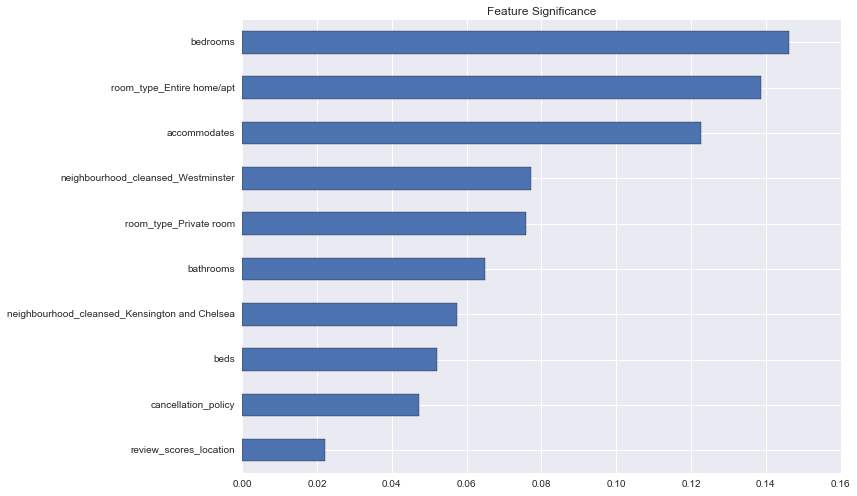

In [68]:
%%time
gbr.fit(X_train, y_train)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(gbr.feature_importances_, index = X_train.columns).sort_values(ascending = False)

plt.figure(figsize=(12, 7))
coef[:10].sort_values(ascending = True).plot(kind = 'barh')
plt.title('Feature Significance')
plt.tight_layout()

## ensemble - AdaBoostRegressor

In [130]:
from sklearn.ensemble import AdaBoostRegressor

In [77]:
abr = AdaBoostRegressor(n_estimators=200, learning_rate=0.05, loss='linear')

In [78]:
%%time
scores_abr = []
kf = KFold(n_splits=10, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = abr.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_abr.append(score)

CPU times: user 3min 40s, sys: 4.93 s, total: 3min 45s
Wall time: 3min 50s


In [79]:
scores_abr

[0.39302510621656445,
 0.39022428216384586,
 0.4030386344753965,
 0.38165506300706753,
 0.3857217593975292,
 0.408151585028601,
 0.4083239949956691,
 0.3867422010832535,
 0.4002673963856239,
 0.3912126758101052]

## XGBoost

- https://www.kaggle.com/mshih2/house-prices-advanced-regression-techniques/using-xgboost-for-feature-selection/notebook

In [18]:
import xgboost as xgb

In [19]:
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.045, learning_rate=0.01, max_depth=20,
                     min_child_weight=1.5, n_estimators=500,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.95)

In [20]:
%%time
scores_xgb = []
kf = KFold(n_splits=5, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_xgb.append(score)

KeyboardInterrupt: 

In [84]:
scores_xgb

[0.3549428456353792,
 0.3545413290647841,
 0.3637357790540472,
 0.34940354556605757,
 0.3474416228953772]

## Start use new training data: price in [30,300] 
- 90% of all the training data; 5% below 30, 5% up 300

In [21]:
data_new_90 = data_new.ix[(data_new['Total_Price'] >=30) & (data_new['Total_Price'] <=300), :-2].copy()
X = data_new_90.ix[:, 1:]
y = data_new_90.ix[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train = X_train.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)

## Baseline Model

In [118]:
data_new_90_bl = data_new.ix[(data_new['Total_Price'] >=30) & (data_new['Total_Price'] <=300), ].copy()
X_bl = data_new_90_bl.ix[:, 1:]
y_bl = data_new_90_bl.ix[:, 0]
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_bl, y_bl, test_size = 0.2, random_state = 123)

In [119]:
bl_price = pd.concat((X_train_bl, y_train_bl), axis = 1).groupby(
    ['neighbourhood_cleansed', 'room_type'])['Total_Price'].mean().reset_index(drop = False)

X_test = pd.merge(X_test_bl, bl_price, on = ['neighbourhood_cleansed', 'room_type'], how = 'left')
y_test = y_test_bl.reset_index(drop = True)
scores_bl = RMSPE(y_test , X_test['Total_Price'])
scores_bl

0.4682110773465417

## LinearRegression

In [120]:
%%time
lr = LinearRegression()
scores_lr = []
for train_idx, test_idx in kf.split(X_train.values):
    X_train_val, y_train_val = X_train.values[train_idx], y_train.values[train_idx]
    X_test_val, y_test_val = X_train.values[test_idx], y_train.values[test_idx]
    score =RMSPE(y_test_val , lr.fit(X_train_val, y_train_val).predict(X_test_val))
    scores_lr.append(score)

CPU times: user 1.8 s, sys: 231 ms, total: 2.03 s
Wall time: 1.28 s


In [121]:
scores_lr

[0.40751834376956697,
 0.38720915046805743,
 0.41267480383094984,
 0.3944530482315441,
 0.4284535513713673,
 0.42827803930435226,
 0.4073264143208664,
 0.4249576143398338,
 0.42117981718241243,
 0.4014360504904277]

## lasso

In [122]:
%%time
alphas = [0.05, 0.1, 0.3, 1, 2, 3, 5, 10]
scores_lasso = []
kf = KFold(n_splits=10, random_state = 123)

for alpha in alphas:
    lasso = Lasso(alpha)
    for train, val in kf.split(X_train):
        score_cv = []
        y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
        score_cv.append(RMSPE(y_train.values[val], y_pred))
        score = np.mean(score_cv)
    scores_lasso.append(score)

CPU times: user 2min 12s, sys: 2.14 s, total: 2min 14s
Wall time: 1min 8s


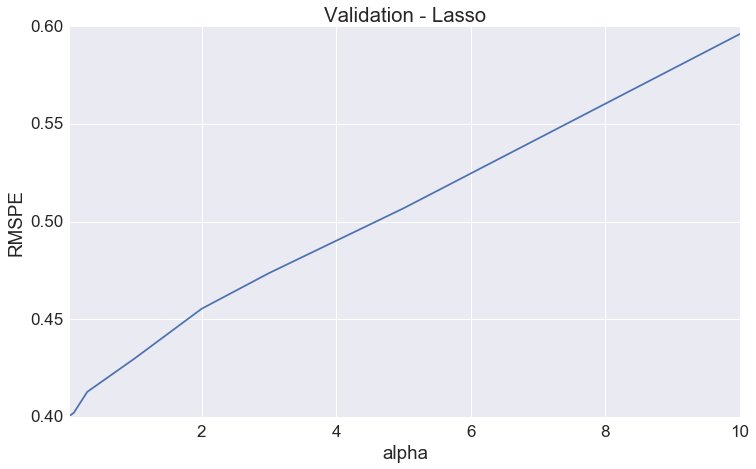

In [123]:
plt.figure(figsize=(12,7))
cv_lasso = pd.Series(scores_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("RMSPE")

In [124]:
cv_lasso.argmin()

0.050000000000000003

In [282]:
%%time
alphas = [  0.5, 0.7, 0.9,  1 ,1.1, 1.2, 1.5, 2.0, 2.5]
scores_lasso = []
kf = KFold(n_splits=10, random_state = 123)

for alpha in alphas:
    lasso = Lasso(alpha)
    for train, val in kf.split(X_train):
        score_cv = []
        y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
        score_cv.append(RMSPE(y_train.values[val], y_pred))
        score = np.mean(score_cv)
    scores_lasso.append(score)

CPU times: user 2min 27s, sys: 49.8 s, total: 3min 16s
Wall time: 2min 45s


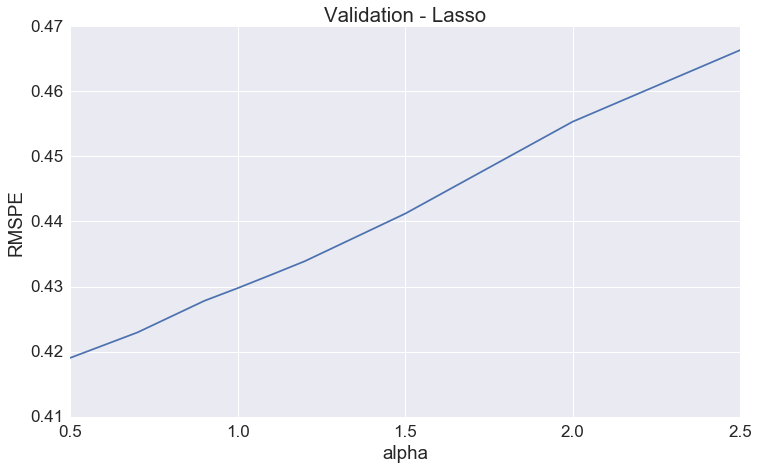

In [283]:
plt.figure(figsize=(12,7))
cv_lasso = pd.Series(scores_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("RMSPE")

In [284]:
cv_lasso.argmin()

0.5

In [84]:
lasso = Lasso(alpha=0.7)

In [144]:
%%time
scores_lasso = []
kf = KFold(n_splits=10, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_lasso.append(score)

CPU times: user 1.32 s, sys: 216 ms, total: 1.53 s
Wall time: 918 ms


In [145]:
scores_lasso

[0.6001715606060056,
 0.5909232653701856,
 0.6099402109882874,
 0.6012777207066604,
 0.6155143675873691,
 0.6340747955379953,
 0.58545505361834,
 0.6123611526043838,
 0.609710065399887,
 0.5960487359739386]

In [92]:
X_test.head()

,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,neighbourhood_cleansed,room_type,Total_Price
0,2,1.0,1.0,1.0,7,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,Hackney,Entire home/apt,132.195504
1,2,1.0,1.0,1.0,1,0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,Wandsworth,Shared room,47.500000
2,2,1.0,1.0,1.0,1,0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,Southwark,Private room,58.966535
3,3,1.0,2.0,3.0,1,12,91.0,10.0,9.0,10.0,...,0,0,0,0,0,0,1,Westminster,Entire home/apt,168.992843
4,4,1.0,1.0,1.0,3,10,94.0,10.0,9.0,10.0,...,0,0,0,0,0,0,1,Newham,Entire home/apt,132.444444


In [95]:
lasso_test = Lasso(alpha=0.7)
y_pred_test = lasso_test.fit(X_train,y_train).predict(X_test)
lasso_score_test = RMSPE(y_test, y_pred_test)
lasso_score_test

0.3671015125711034

In [96]:
lasso_variable = pd.DataFrame({'variable':data_new_90.columns.tolist()[1:], 'coef':lasso_test.coef_})
lasso_intercept = pd.DataFrame({'variable':'constant', 'coef':lasso_test.intercept_}, index = range(1))
lasso_func = pd.concat((lasso_intercept, lasso_variable), axis = 0).reset_index(drop = 1)
lasso_func[lasso_func['coef']!=0]

,coef,variable
0,38.576057,constant
1,8.261645,accommodates
2,4.626998,bathrooms
3,15.987746,bedrooms
5,0.006832,minimum_nights
6,-0.027903,number_of_reviews
7,0.177651,review_scores_rating
9,0.925994,review_scores_cleanliness
10,-1.150094,review_scores_checkin
11,-2.827179,review_scores_communication


## Bagging

In [125]:
bagging = BaggingRegressor(n_estimators=100, max_samples=1.0, max_features=0.4)

In [126]:
%%time
scores_bagging = []
kf = KFold(n_splits=10, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = bagging.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_bagging.append(score)

CPU times: user 1min 46s, sys: 3.93 s, total: 1min 50s
Wall time: 1min 55s


In [127]:
scores_bagging

[0.4421190727100486,
 0.40867858018692294,
 0.4449859560274344,
 0.4432459209911838,
 0.46152489516525474,
 0.4318726196914459,
 0.4349657130996934,
 0.46197270628771303,
 0.4392918090129665,
 0.41352729449049375]

## RandomForestRegressor

In [134]:
%%time
scores_rfr = []

clf = RandomForestRegressor(n_estimators=50, n_jobs=-1)
for train, val in kf.split(X_train):
    y_pred = clf.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_rfr.append(score)

CPU times: user 3min 20s, sys: 2.09 s, total: 3min 22s
Wall time: 58.1 s


In [135]:
scores_rfr

[0.3821457599636585,
 0.3821681473106954,
 0.409955424501423,
 0.3758541273692783,
 0.4252775162795725,
 0.39908812251325554,
 0.3826426774756847,
 0.410414357345481,
 0.396461423064827,
 0.3719271489605243]

In [95]:
X = data_new_90.ix[:, 1:]
y = np.log(data_new_90.ix[:, 0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train = X_train.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)

In [ ]:
### Try Log(Price)

In [96]:
%%time
scores_90_log = []

clf = RandomForestRegressor(n_estimators=50, n_jobs=-1)
for train, val in kf.split(X_train):
    y_pred = clf.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_90_log.append(score)
    
scores_90

CPU times: user 1min 27s, sys: 1.15 s, total: 1min 28s
Wall time: 27.3 s


In [97]:
scores_90_log

[0.07326398868212304,
 0.07347345068859007,
 0.07394663631195127,
 0.07393427948121231,
 0.07179579625927794]

## AdaBoostRegressor

In [136]:
abr = AdaBoostRegressor(n_estimators=200, learning_rate=0.05, loss='linear')

In [137]:
%%time
scores_abr = []
kf = KFold(n_splits=10, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = abr.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_abr.append(score)

CPU times: user 3min 6s, sys: 3.89 s, total: 3min 9s
Wall time: 3min 11s


In [138]:
scores_abr

[0.5698672033020349,
 0.5711301733219654,
 0.5846940381047641,
 0.584682106224545,
 0.6089200641475273,
 0.5779033552682666,
 0.568740539200803,
 0.5996435914537256,
 0.5975914740857371,
 0.5753253122879755]

## XGBoost

In [22]:
import xgboost as xgb

In [23]:
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.045, learning_rate=0.1, max_depth=20,
                     min_child_weight=1.5, n_estimators=100,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.8)

In [26]:
%%time
scores_xgb = []
kf = KFold(n_splits=10, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_xgb.append(score)
    

CPU times: user 2min 18s, sys: 893 ms, total: 2min 19s
Wall time: 2min 19s


In [27]:
scores_xgb

[0.393105922874738,
 0.38694985222911904,
 0.40691212136612764,
 0.369332523833457,
 0.4072720556583928,
 0.39183821164410526,
 0.3776967774733984,
 0.40752727249042275,
 0.4011128499081938,
 0.3739395403785528]

## Plot Model performance over each iteration

In [149]:
scores_summary = pd.DataFrame({'LinearRegression':scores_lr,  'Bagging':scores_bagging,
                              'RandomForest':scores_rfr, 'GrandientBoost':scores_xgb})

In [150]:
scores_summary['BaseLine'] = scores_bl
scores_summary

,Bagging,GrandientBoost,LinearRegression,RandomForest,BaseLine
0,0.442119,0.393106,0.407518,0.382146,0.468211
1,0.408679,0.386950,0.387209,0.382168,0.468211
2,0.444986,0.406912,0.412675,0.409955,0.468211
3,0.443246,0.369333,0.394453,0.375854,0.468211
4,0.461525,0.407272,0.428454,0.425278,0.468211
5,0.431873,0.391838,0.428278,0.399088,0.468211
6,0.434966,0.377697,0.407326,0.382643,0.468211
7,0.461973,0.407527,0.424958,0.410414,0.468211
8,0.439292,0.401113,0.421180,0.396461,0.468211
9,0.413527,0.373940,0.401436,0.371927,0.468211


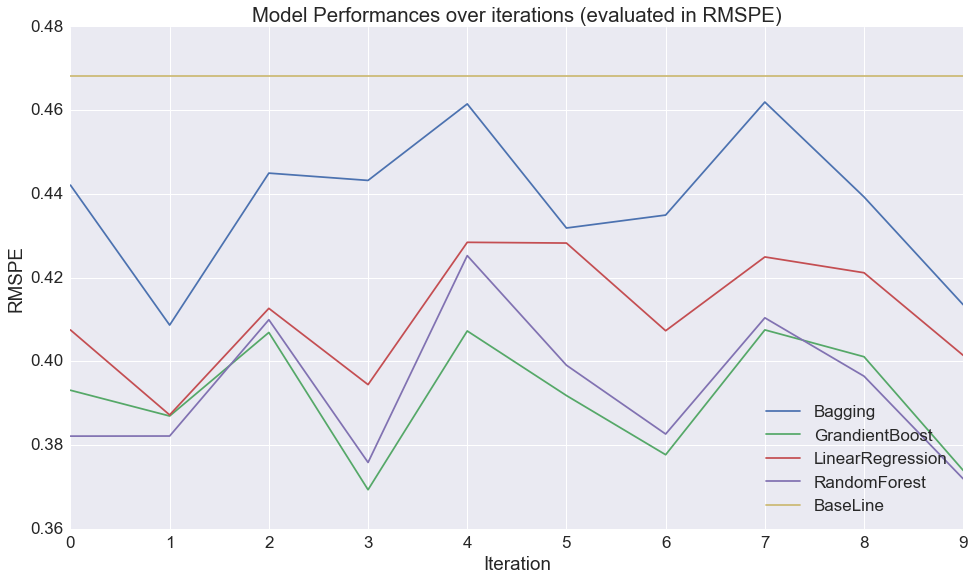

In [151]:
scores_summary.plot(figsize = (16,9))
plt.xlabel('Iteration')
plt.ylabel('RMSPE')
plt.title('Model Performances over iterations (evaluated in RMSPE)')

## XGBoost Model Tuning

#### learning_rate & n_estimators

In [334]:
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, learning_rate=0.1, max_depth=10,
                     min_child_weight=1.5, n_estimators=100,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.8)


In [335]:
%%time
scores_xgb = []
kf = KFold(n_splits=5, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_xgb.append(score)
    

CPU times: user 26.8 s, sys: 232 ms, total: 27 s
Wall time: 27.2 s


In [336]:
np.mean(scores_xgb)


0.36892406717535037

In [333]:
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, learning_rate=0.02, max_depth=10,
                     min_child_weight=1.5, n_estimators=500,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.8)


In [292]:
%%time
scores_xgb = []
kf = KFold(n_splits=5, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_xgb.append(score)

CPU times: user 2min 18s, sys: 954 ms, total: 2min 19s
Wall time: 2min 23s


In [293]:
scores_xgb

[0.3519427803690051,
 0.3613908058138314,
 0.37165407801492634,
 0.3688682982848708,
 0.3615963822564256]

In [294]:
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, learning_rate=0.01, max_depth=10,
                     min_child_weight=1.5, n_estimators=1000,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.8)

In [295]:
%%time
scores_xgb = []
kf = KFold(n_splits=5, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_xgb.append(score)

CPU times: user 4min 39s, sys: 1.75 s, total: 4min 41s
Wall time: 4min 47s


In [296]:
scores_xgb

[0.3515375592732779,
 0.36066239986305226,
 0.37029817965521394,
 0.3695855807471209,
 0.3608789547315796]

#### max_depth &  min_child_weight

In [297]:
max_depths = [3,5,10,15] 
min_child_weights = [1, 1.5,2,3]

In [299]:
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, learning_rate=0.1, max_depth=10,
                     min_child_weight=1.5, n_estimators=100,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.8)

In [309]:
%%time
colsample_bytree=0.4, gamma=0.05, learning_rate=0.1, max_depth=10,
                     min_child_weight=1.5, n_estimators=100,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.8)
        
scores_xgb = []
scores = []
kf = KFold(n_splits=5, random_state = 123)
for maxd in max_depths:
    for minc in min_child_weights:
        est = est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, learning_rate=0.1, max_depth=maxd,
                     min_child_weight=minc, n_estimators=100,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.8)
        for train, val in kf.split(X_train):
            y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
            score = RMSPE(y_train.values[val], y_pred)
            scores.append(score)
        scores_xgb.append(np.mean(scores))

CPU times: user 6min 25s, sys: 5.87 s, total: 6min 31s
Wall time: 6min 53s


In [307]:
scores_xgb = pd.DataFrame(scores_xgb)

In [310]:
scores_xgb

[0.38814553998252049,
 0.38823862836877321,
 0.38826965783085743,
 0.38829365834990381,
 0.38552892850578824,
 0.38377094139091644,
 0.38251523630886519,
 0.38156397052272223,
 0.38013855087320986,
 0.37901710250342391,
 0.37809955383723531,
 0.37726412255752922,
 0.37762070349544752,
 0.37774525021531952,
 0.3778531907058752,
 0.37777362397928316]

In [315]:
max_depths = [10,15,20,25] 
min_child_weights = [2,3]

In [317]:
%%time

scores_xgb = []
scores = []
kf = KFold(n_splits=5, random_state = 123)
for maxd in max_depths:
    for minc in min_child_weights:
        est = est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, learning_rate=0.1, max_depth=maxd,
                     min_child_weight=minc, n_estimators=100,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.8)
        for train, val in kf.split(X_train):
            y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
            score = RMSPE(y_train.values[val], y_pred)
            scores.append(score)
        scores_xgb.append(np.mean(scores))

CPU times: user 6min 56s, sys: 3.07 s, total: 6min 59s
Wall time: 7min 2s


In [318]:
scores_xgb

[0.36892406717535037,
 0.36849922282805619,
 0.37212093440992239,
 0.37323573157754253,
 0.37623185940852816,
 0.3775669419705559,
 0.37987655867070885,
 0.381070521562276]

In [320]:
%%time

min_child_weights = [3,4,5,6,7,8,9,10]
scores_xgb = []
scores = []
kf = KFold(n_splits=5, random_state = 123)
for minc in min_child_weights:
    est = est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, learning_rate=0.1, max_depth=10,
                               min_child_weight=minc, n_estimators=100,  reg_alpha=0.65, reg_lambda=0.45, subsample=0.8)
    for train, val in kf.split(X_train):
        y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
        score = RMSPE(y_train.values[val], y_pred)
        scores.append(score)
    scores_xgb.append(np.mean(scores))
        

CPU times: user 3min 33s, sys: 2.13 s, total: 3min 35s
Wall time: 3min 38s


In [321]:
scores_xgb

[0.36807437848076197,
 0.36792045082308722,
 0.36805895172811259,
 0.36807287565781011,
 0.36805444216156552,
 0.36806679521048064,
 0.36812420512869648,
 0.36802838883671302]

#### gamma

In [323]:
%%time

gammas= np.arange(0,0.6,0.05)
scores_xgb = []
scores = []
kf = KFold(n_splits=5, random_state = 123)
for g in gammas:
    est = est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=g, learning_rate=0.1, max_depth=10,
                               min_child_weight=4, n_estimators=100,  reg_alpha=0.65, reg_lambda=0.45, subsample=0.8)
    for train, val in kf.split(X_train):
        y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
        score = RMSPE(y_train.values[val], y_pred)
        scores.append(score)
    scores_xgb.append([np.mean(scores),np.std(scores)])

CPU times: user 5min 31s, sys: 4.3 s, total: 5min 35s
Wall time: 5min 47s


In [324]:
scores_xgb

[0.36788647536534802,
 0.36782649926538025,
 0.36777557481738066,
 0.36775011259338092,
 0.36772804928412134,
 0.36771333443096971,
 0.367702732737618,
 0.3677471526243552,
 0.36777452564349949,
 0.36779641948780895,
 0.36778829630174298,
 0.3677845650996534]

#### subsample & colsample_bytree

In [328]:
%%time

subsamples = [0.4, 0.5,0.7,0.8,0.9]
colsamples = [0.2, 0.4, 0.6,0.8]
scores_xgb = []
scores = []
kf = KFold(n_splits=5, random_state = 123)
for s in subsamples:
    for c in colsamples:       
        est=xgb.XGBRegressor(colsample_bytree=c, subsample=s ,gamma=0.3, learning_rate=0.1, max_depth=10,
                               min_child_weight=4, n_estimators=100,  reg_alpha=0.65, reg_lambda=0.45)
        for train, val in kf.split(X_train):
            y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
            score = RMSPE(y_train.values[val], y_pred)
            scores.append(score)
        scores_xgb.append([np.mean(scores),np.std(scores)])

CPU times: user 11min 26s, sys: 8.22 s, total: 11min 35s
Wall time: 11min 59s


In [329]:
scores_xgb

[[0.38079872602982368, 0.0036273707950476375],
 [0.37702807879636646, 0.0057272591803919993],
 [0.3749958759816181, 0.0068192310592109576],
 [0.3740702758184356, 0.0069504175367549517],
 [0.37493857727425906, 0.0066051227798462533],
 [0.37433357102445092, 0.0067824615951812463],
 [0.3738141600074476, 0.0068728042242341232],
 [0.37334174791968394, 0.0069784367850349452],
 [0.37368119209147949, 0.0068249056418443425],
 [0.37313819444920976, 0.0069374180135031872],
 [0.37266953409740822, 0.0071068698327083494],
 [0.37229148950228269, 0.0070926342568309909],
 [0.37236725295861844, 0.0069179637983780963],
 [0.37202952935996769, 0.0070089002681208382],
 [0.37176313579781861, 0.0071124233853661414],
 [0.37160296339960808, 0.007038588125427318],
 [0.37179306330341261, 0.0069278701986364042],
 [0.37151860123777708, 0.0070162266881126159],
 [0.37127591080905614, 0.0071134950758414348],
 [0.37110299061208374, 0.0071179295159605385]]

In [330]:
%%time

alphas = [0, 0.2,0.4,0.6]
lambdas = [0, 0.5, 0.6,1, 2]
scores_xgb = []
scores = []
kf = KFold(n_splits=5, random_state = 123)
for a in alphas:
    for l in lambdas:       
        est=xgb.XGBRegressor(colsample_bytree=0.9, subsample=0.9 ,gamma=0.3, learning_rate=0.1, max_depth=10,
                               min_child_weight=4, n_estimators=100,  reg_alpha=a, reg_lambda=l)
        for train, val in kf.split(X_train):
            y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
            score = RMSPE(y_train.values[val], y_pred)
            scores.append(score)
        scores_xgb.append([np.mean(scores),np.std(scores)])

CPU times: user 15min 48s, sys: 6.29 s, total: 15min 54s
Wall time: 16min 2s


In [331]:
scores_xgb

[[0.37024863980894074, 0.0061794343678060323],
 [0.36893704361144547, 0.0064216767694425091],
 [0.36875682457872727, 0.0065776871559551876],
 [0.36829771706318037, 0.0063999474443953821],
 [0.36777857724329943, 0.0065902012107041438],
 [0.36803057709508447, 0.0065938741438050959],
 [0.36801263974810627, 0.0065487320291313369],
 [0.36790129224057155, 0.0065138314911880402],
 [0.36775937784418672, 0.006459671742223414],
 [0.3675021891019008, 0.0064113592632400939],
 [0.3676255469531734, 0.0064874086822423859],
 [0.36762892469985198, 0.0064241560122686491],
 [0.36761485903188318, 0.0063999670198456289],
 [0.36755741546813908, 0.0063775887969906853],
 [0.36741249988191704, 0.0063712363804172781],
 [0.36755074136844512, 0.0063826942346712602],
 [0.36759421596333219, 0.0063813436513504721],
 [0.36754782294673005, 0.0063274887648921609],
 [0.36754215004191876, 0.0062785671830798929],
 [0.36741588942087633, 0.0062851674564837982]]

#### reg_lambda & reg_alpha

In [338]:
%%time

alphas = [0.6, 0.8,1.0,1.5]
lambdas = [2, 3, 5]
scores_xgb = []
scores = []
kf = KFold(n_splits=5, random_state = 123)
for a in alphas:
    for l in lambdas:       
        est=xgb.XGBRegressor(colsample_bytree=0.9, subsample=0.9 ,gamma=0.3, learning_rate=0.1, max_depth=10,
                               min_child_weight=4, n_estimators=100,  reg_alpha=a, reg_lambda=l)
        for train, val in kf.split(X_train):
            y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
            score = RMSPE(y_train.values[val], y_pred)
            scores.append(score)
        scores_xgb.append([np.mean(scores),np.std(scores)])

CPU times: user 9min 53s, sys: 5.75 s, total: 9min 59s
Wall time: 10min 33s


In [339]:
scores_xgb

[[0.36501693762106996, 0.0059178564246240408],
 [0.36492377404071646, 0.0064313584336314631],
 [0.3645317984472693, 0.0064198027498423267],
 [0.36463235946604972, 0.006522790135750375],
 [0.36472697385171865, 0.0065419317858061354],
 [0.36464606838178992, 0.0064409516064089537],
 [0.36471845189543545, 0.0063822164988511839],
 [0.36469402516919419, 0.0065027220360896277],
 [0.36466892725204053, 0.0064441894050984881],
 [0.36463776735526321, 0.0064451538118050471],
 [0.3646499060097077, 0.006520678130459371],
 [0.36459217314056847, 0.0064982491312059699]]

In [354]:
est=xgb.XGBRegressor(colsample_bytree=0.9, gamma=0.3, learning_rate=0.01, max_depth=10,
                     min_child_weight=4, n_estimators=1000,  
                     reg_alpha=0.65, reg_lambda=5, subsample=0.9)


In [341]:
%%time
scores_xgb = []
kf = KFold(n_splits=5, random_state = 123)
for train, val in kf.split(X_train):
    y_pred = est.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
    score = RMSPE(y_train.values[val], y_pred)
    scores_xgb.append(score)

CPU times: user 8min 20s, sys: 4 s, total: 8min 24s
Wall time: 8min 39s


In [343]:
np.mean(scores_xgb)

0.36148407551730782

In [359]:
xgb_params = {"objective": "reg:linear", "eta": 0.01, "max_depth": 10, "seed": 42, "silent": 1,
             'colsample_bytree':0.9, 'gamma':0.3,  'min_child_weight':4,
                     'reg_alpha':0.65, 'reg_lambda':5, 'subsample':0.9}
num_rounds = 1000

dtrain = xgb.DMatrix(X_train, label=y_train)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)


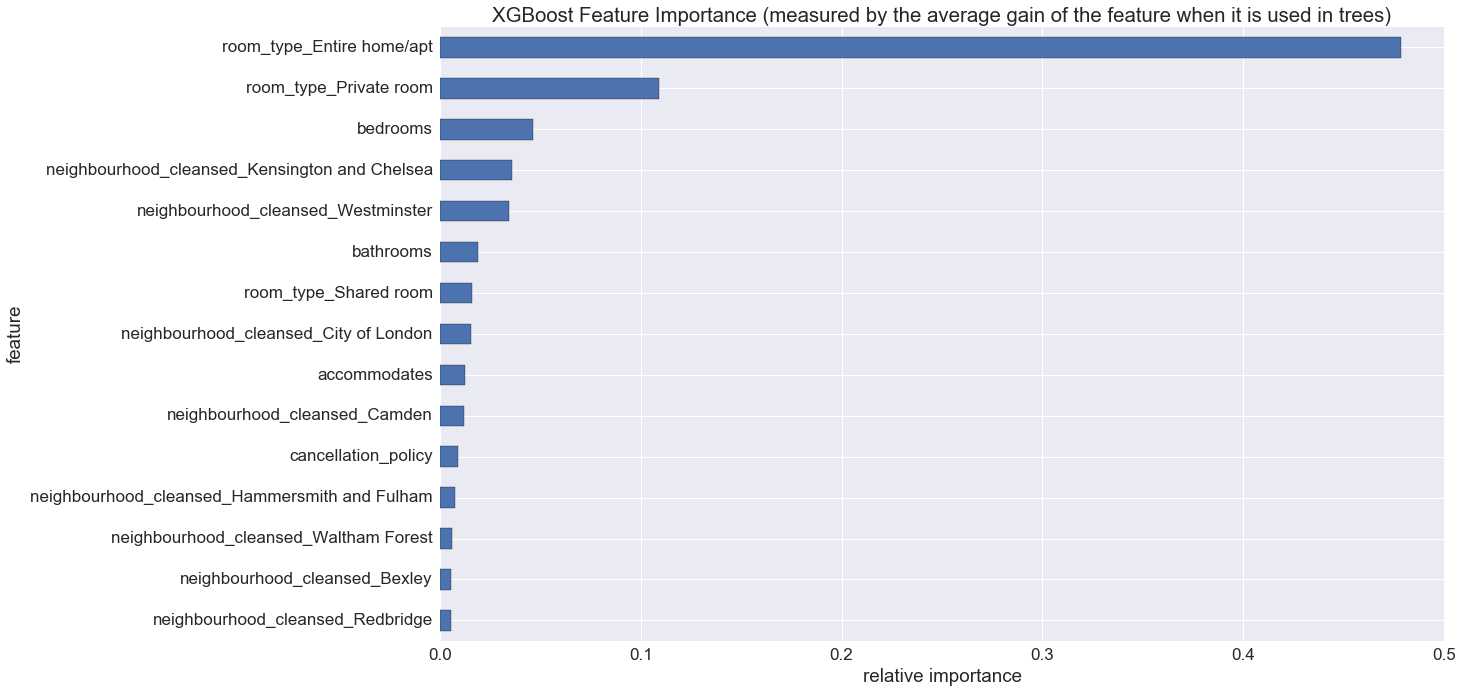

In [386]:
importance = gbdt.get_score(importance_type='gain')
importance = sorted(importance.items(), key = lambda x:x[1], reverse = True)
df = pd.DataFrame(importance, columns=['feature', 'fscore']).sort_values(by = 'fscore')
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-15:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(18, 11))
plt.title('XGBoost Feature Importance (measured by the average gain of the feature when it is used in trees)')
plt.xlabel('relative importance')

In [387]:
data_new_90 = data_new.ix[(data_new['Total_Price'] >=30) & (data_new['Total_Price'] <=300), :-2].copy()
X = data_new_90.ix[:, 1:]
y = data_new_90.ix[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train = X_train.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)

In [388]:
%%time
est=xgb.XGBRegressor(colsample_bytree=0.9, gamma=0.3, learning_rate=0.01, max_depth=10,
                     min_child_weight=4, n_estimators=1000,  
                     reg_alpha=0.65, reg_lambda=5, subsample=0.9)
y_pred_est = est.fit(X_train,y_train).predict(X_test)


CPU times: user 2min 5s, sys: 1.52 s, total: 2min 6s
Wall time: 2min 13s


In [389]:
RMSPE(y_test, y_pred_est)

0.36289876308784536

In [390]:
data_error_xgb = pd.concat((X_test, y_test, pd.DataFrame(y_pred_est)), axis = 1)
col = data_error_xgb.columns.tolist()
col[-1] = 'Total_Price_Pred'
data_error_xgb.columns = col
data_error_xgb['Error'] = data_error_xgb['Total_Price_Pred'] - data_error_xgb['Total_Price']
data_error_xgb['Error_Rate'] = data_error_xgb['Error'] / data_error_xgb['Total_Price']

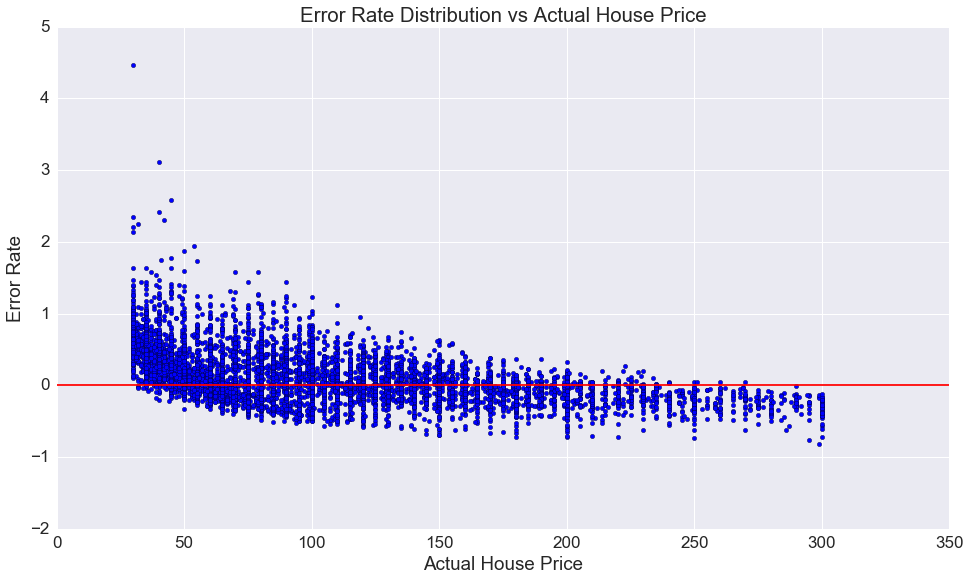

In [391]:
plt.figure(figsize = (16,9))
plt.scatter(data_error_xgb['Total_Price'], data_error_xgb['Error_Rate'])
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')
plt.title('Error Rate Distribution vs Actual House Price')
plt.xlabel('Actual House Price')
plt.ylabel('Error Rate')

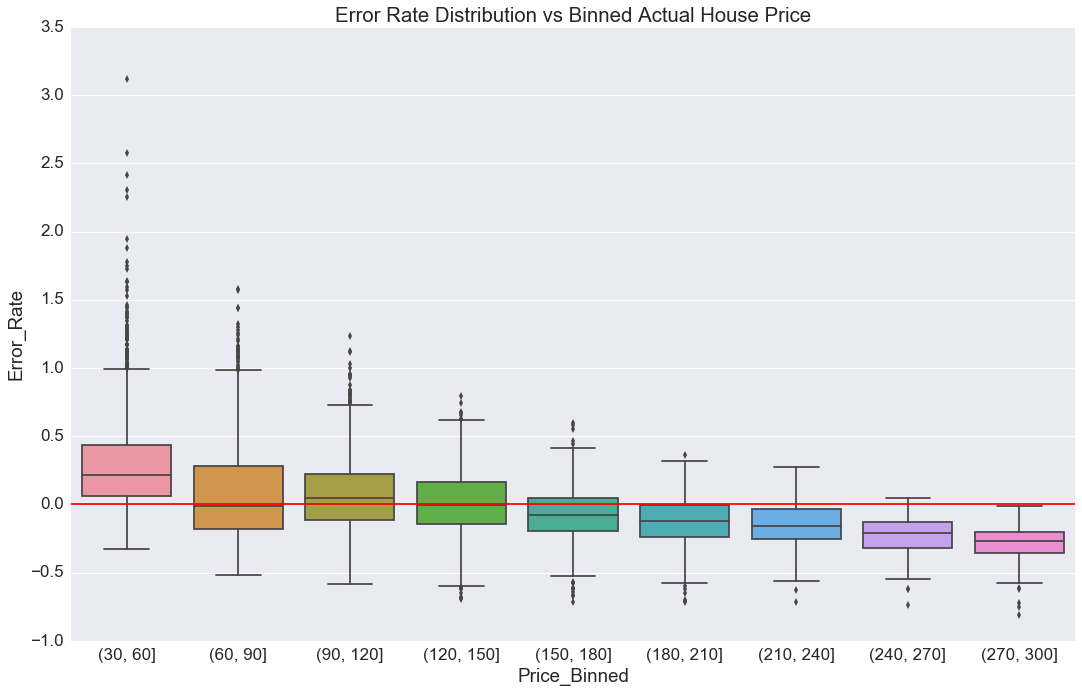

In [397]:
bins = np.linspace(30,300, 10)
data_error_xgb['Price_Binned'] = pd.cut(data_error_xgb['Total_Price'], bins = bins)
plt.figure(figsize = (18,11))
sns.boxplot(x = data_error_xgb['Price_Binned'] , y = data_error_xgb['Error_Rate'] )
plt.title('Error Rate Distribution vs Binned Actual House Price')
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')

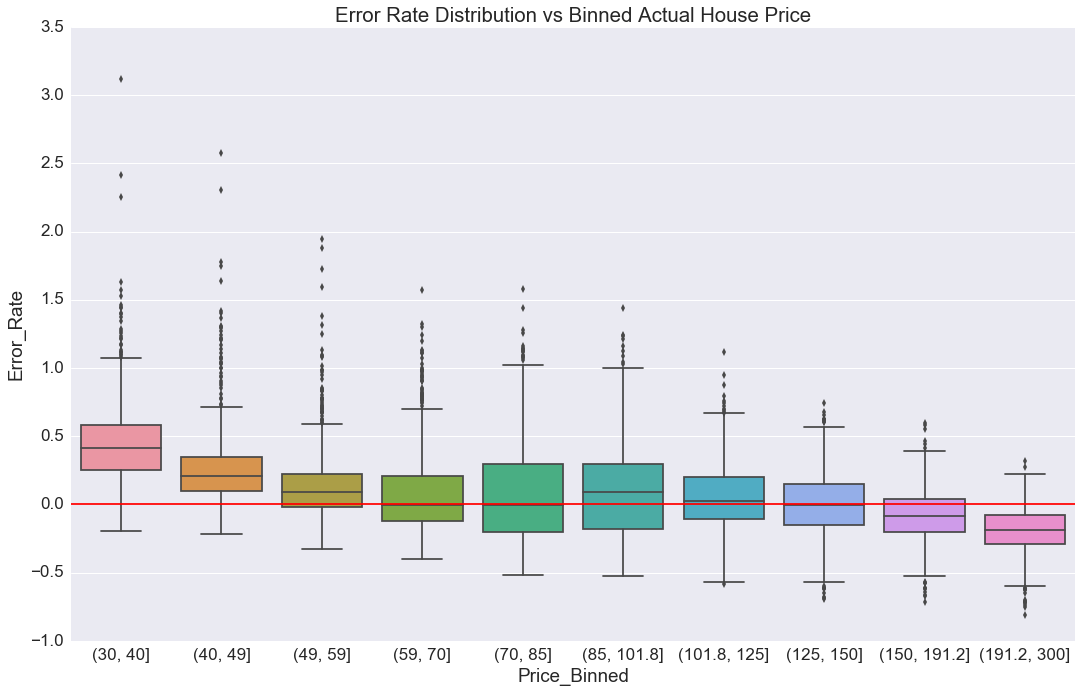

In [392]:
bins_10 = data_error_xgb['Total_Price'].quantile(np.arange(0,1.1,0.1))
data_error_xgb['Price_Binned'] = pd.cut(data_error_xgb['Total_Price'], bins = bins_10)
plt.figure(figsize = (18,11))
sns.boxplot(x = data_error_xgb['Price_Binned'] , y = data_error_xgb['Error_Rate'] )
plt.title('Error Rate Distribution vs Binned Actual House Price')
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')

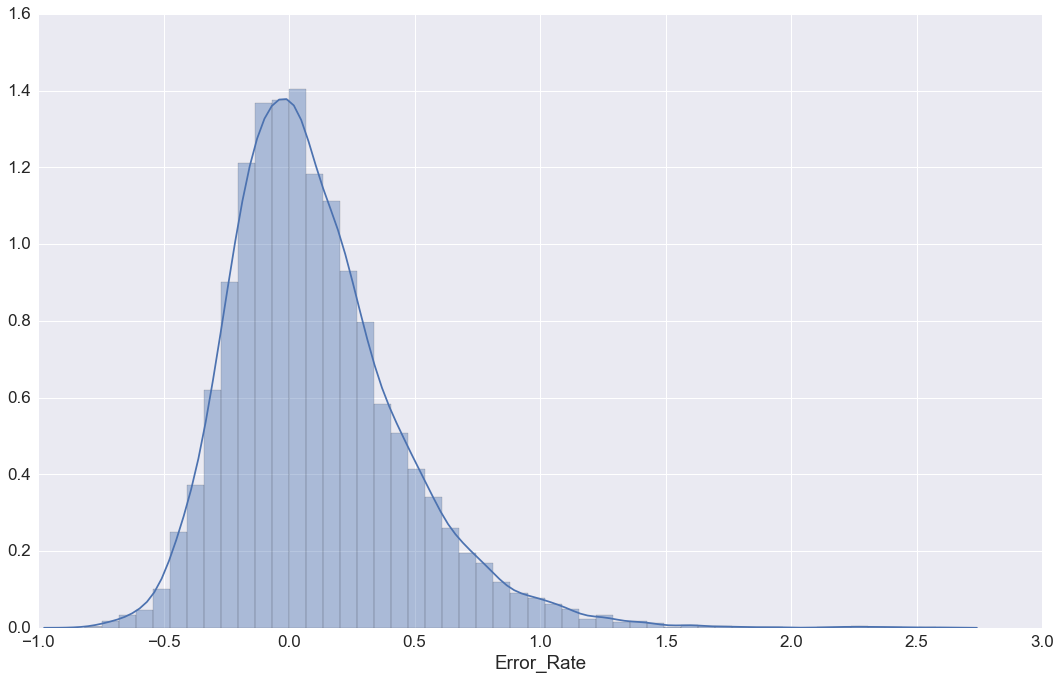

In [393]:
plt.figure(figsize =(18,11) )
sns.distplot(data_error_xgb.ix[data_error_xgb['Error_Rate']<=3,'Error_Rate' ], );

## Plot Error distribution - RandomForestRegressor

In [152]:
X = data_new_90.ix[:, 1:]
y = data_new_90.ix[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train = X_train.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)
rfr = RandomForestRegressor(n_estimators=50, n_jobs=-1)
y_pred = rfr.fit(X_train,y_train).predict(X_train)

In [233]:
y_train.shape

(30832,)

In [153]:
data_error = pd.concat((X_train, y_train, pd.DataFrame(y_pred)), axis = 1)

In [154]:
col = data_error.columns.tolist()
col[-1] = 'Total_Price_Pred'
data_error.columns = col
data_error['Error'] = data_error['Total_Price_Pred'] - data_error['Total_Price']
data_error['Error_Rate'] = data_error['Error'] / data_error['Total_Price']

'When Price is low, we tend to over-predict the price; When Price is high, we tend to under-predict\npredict the price '

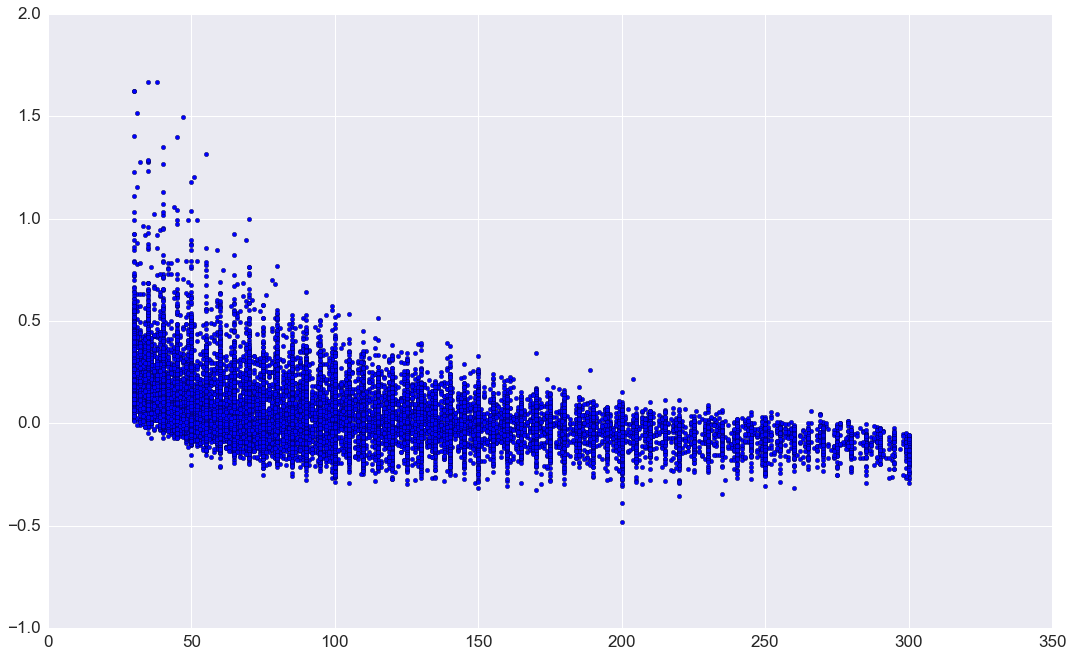

In [155]:
plt.figure(figsize = (18,11))
plt.scatter(data_error['Total_Price'], data_error['Error_Rate'])
'''When Price is low, we tend to over-predict the price; When Price is high, we tend to under-predict
predict the price '''

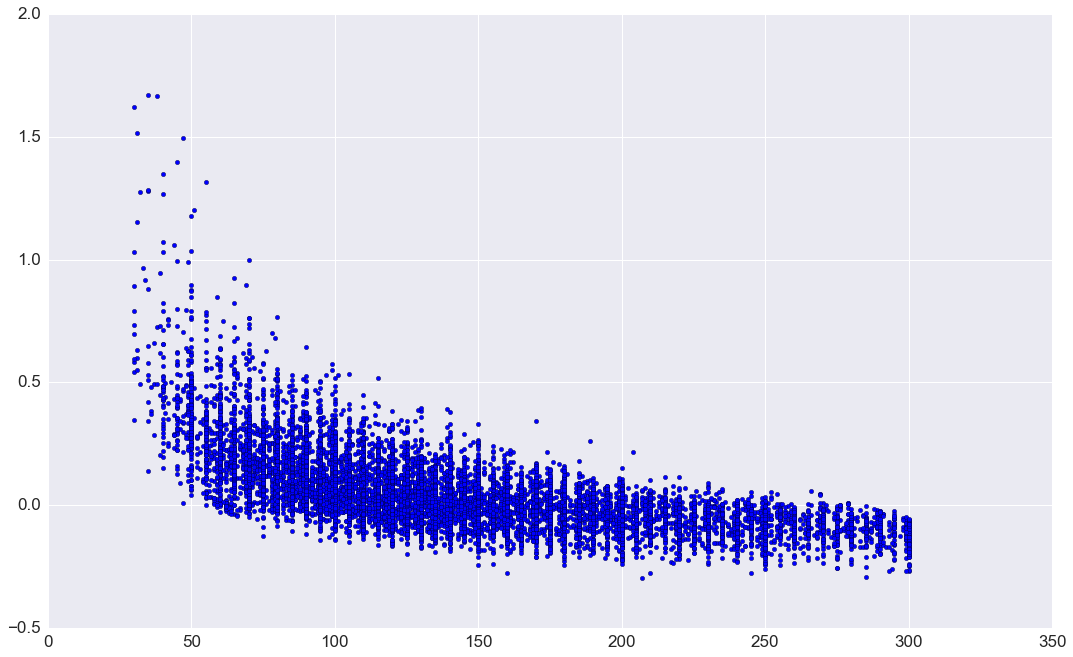

In [156]:
plt.figure(figsize = (18,11))
plt.scatter(data_error.ix[data_error['room_type_Entire home/apt'] == 1, 'Total_Price']
            , data_error.ix[data_error['room_type_Entire home/apt'] == 1, 'Error_Rate'])

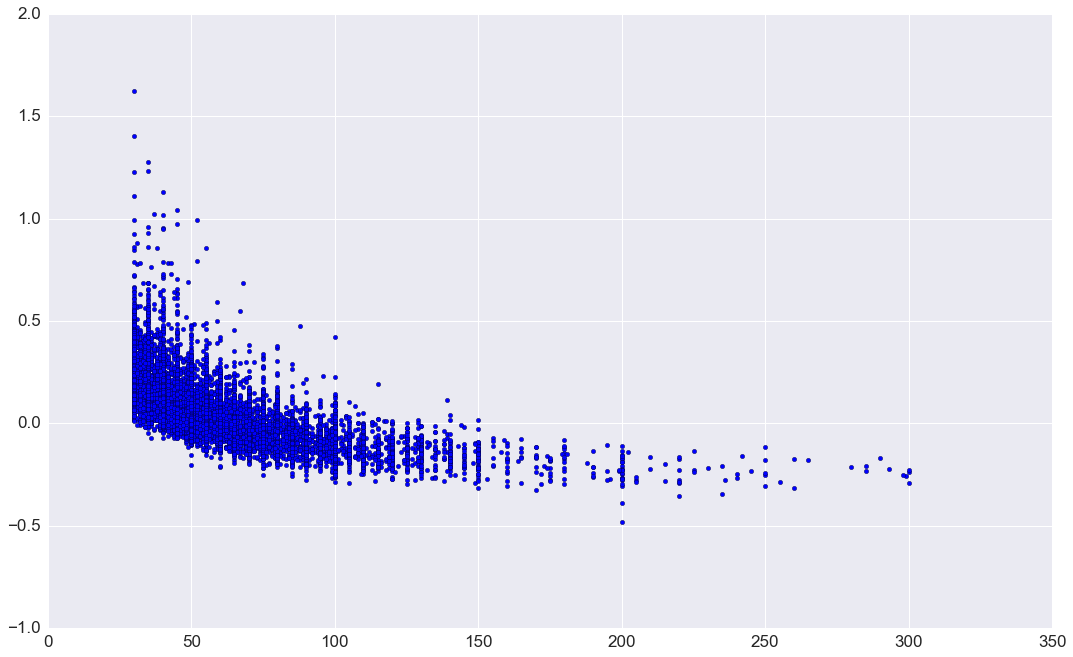

In [157]:
plt.figure(figsize = (18,11))
plt.scatter(data_error.ix[data_error['room_type_Private room'] == 1, 'Total_Price']
            , data_error.ix[data_error['room_type_Private room'] == 1, 'Error_Rate'])
## Try to add two lines (upper - lower limit of the scatter plot, like 90% of the point is in this area)

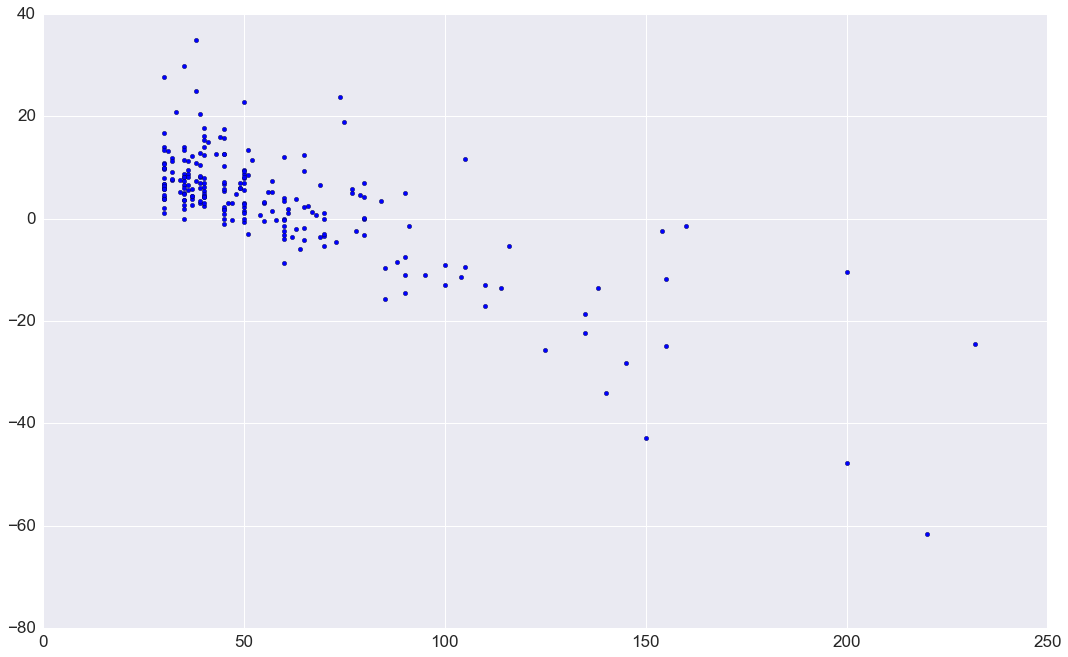

In [158]:
plt.figure(figsize = (18,11))
plt.scatter(data_error.ix[data_error['room_type_Shared room'] == 1, 'Total_Price']
            , data_error.ix[data_error['room_type_Shared room'] == 1, 'Error'])

In [159]:
### Categorize the Price into 20 bins
bins = np.linspace(30,300, 20)
data_error['Price_Bined'] = pd.cut(data_error['Total_Price'], bins = bins)

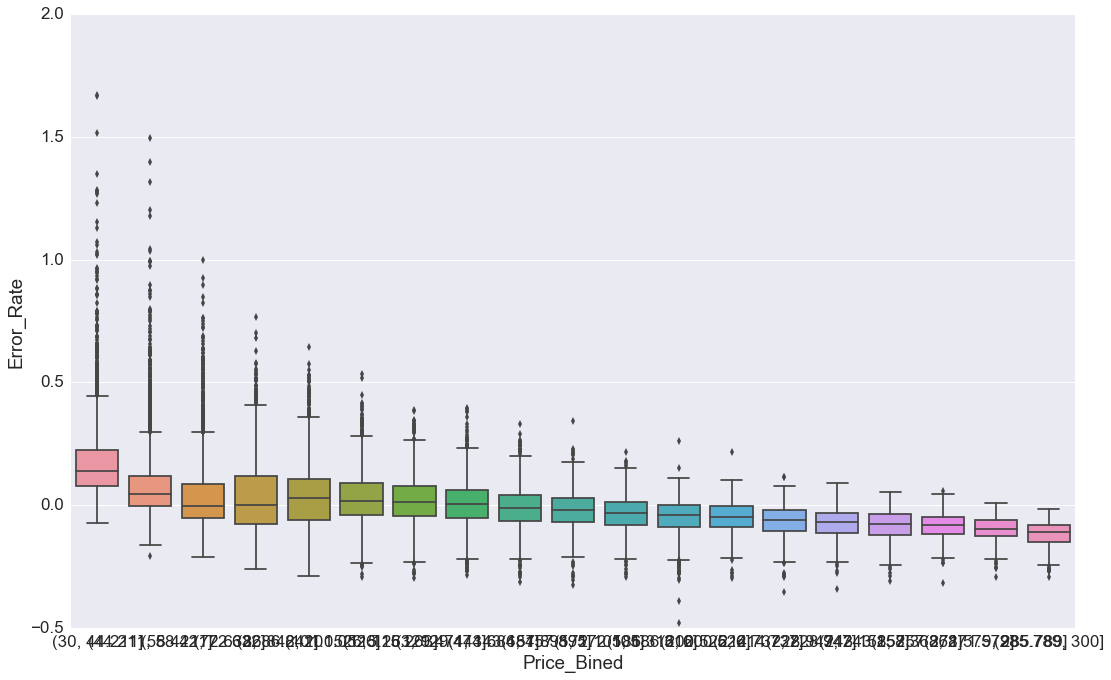

In [160]:
plt.figure(figsize = (18,11))
sns.boxplot(x = data_error['Price_Bined'] , y = data_error['Error_Rate'] )

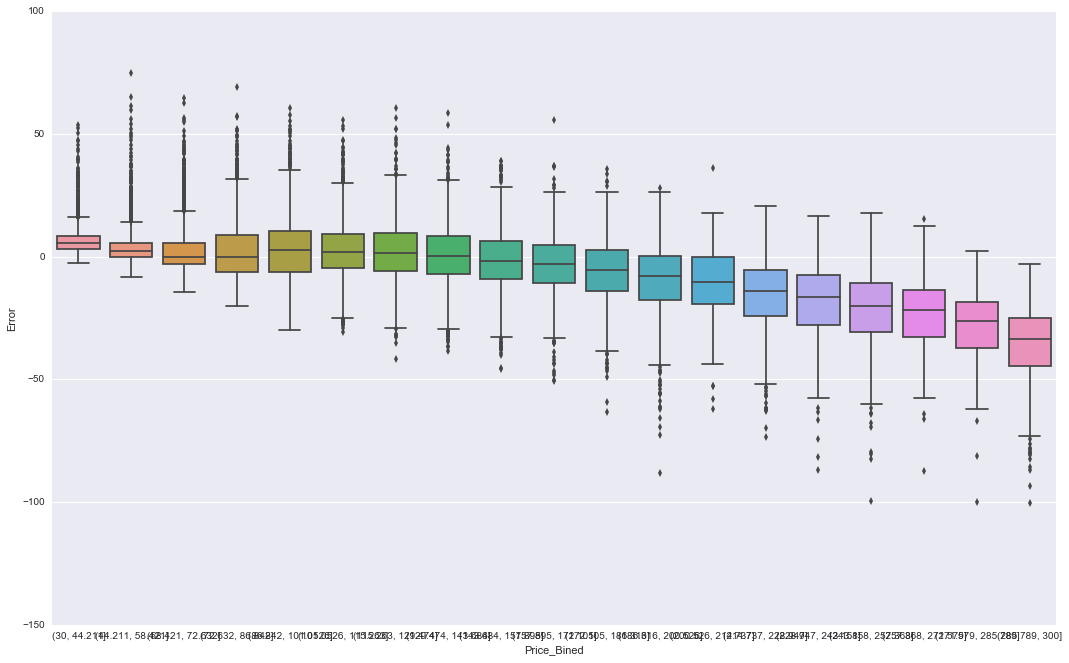

In [246]:
plt.figure(figsize = (18,11))
sns.boxplot(x = data_error['Price_Bined'] , y = data_error['Error'] , data = data_error )

## Plot Error distribution - Lasso

In [247]:
X = data_new_90.ix[:, 1:]
y = data_new_90.ix[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train = X_train.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)
lasso = Lasso(1.5)
y_pred = lasso.fit(X_train,y_train).predict(X_train)

In [248]:
data_error = pd.concat((X_train, y_train, pd.DataFrame(y_pred)), axis = 1)
col = data_error.columns.tolist()
col[-1] = 'Total_Price_Pred'
data_error.columns = col
data_error['Error'] = data_error['Total_Price_Pred'] - data_error['Total_Price']
data_error['Error_Rate'] = data_error['Error'] / data_error['Total_Price']

'When Price is low, we tend to over-predict the price; When Price is high, we tend to under-predict\npredict the price '

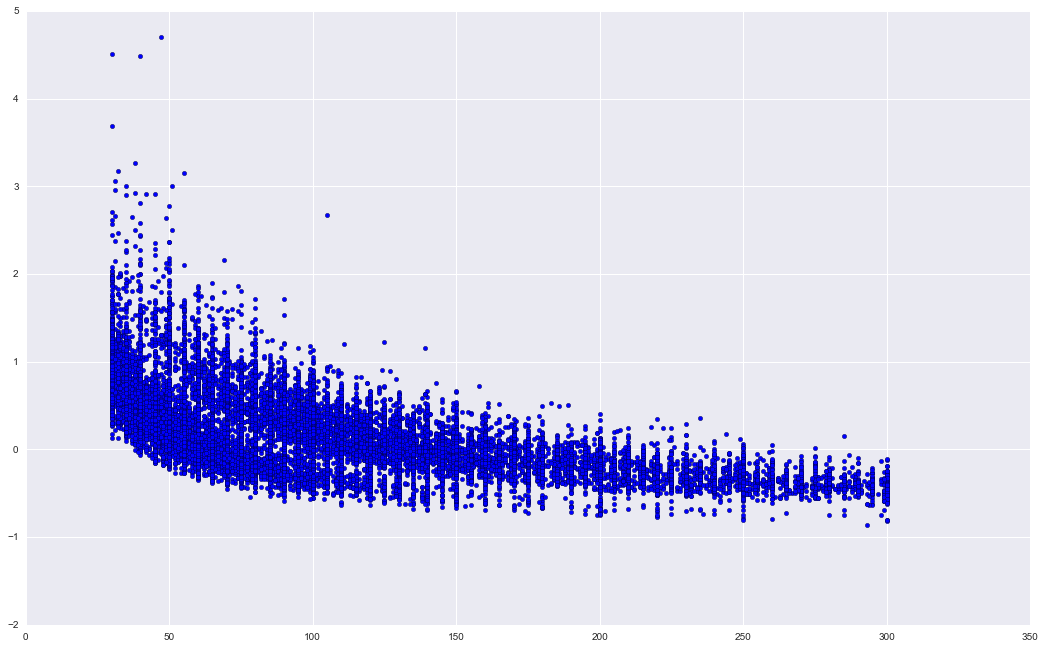

In [249]:
plt.figure(figsize = (18,11))
plt.scatter(data_error['Total_Price'], data_error['Error_Rate'])
'''When Price is low, we tend to over-predict the price; When Price is high, we tend to under-predict
predict the price '''

In [262]:
### Categorize the Price into 10 bins
bins = np.linspace(30,300, 10)
data_error['Price_Bined'] = pd.cut(data_error['Total_Price'], bins = bins)

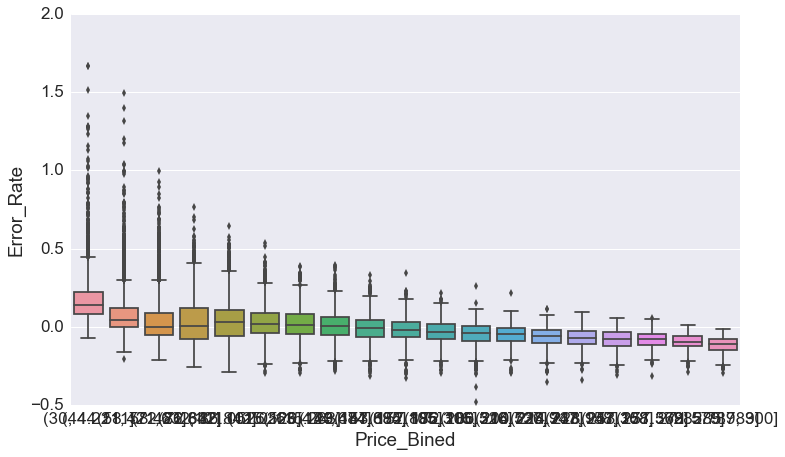

In [183]:
plt.figure(figsize = (12,7))
sns.boxplot(x = data_error['Price_Bined'] , y = data_error['Error_Rate'] )

In [264]:
bins_10 = data_error['Total_Price'].quantile(np.arange(0,1.1,0.1))

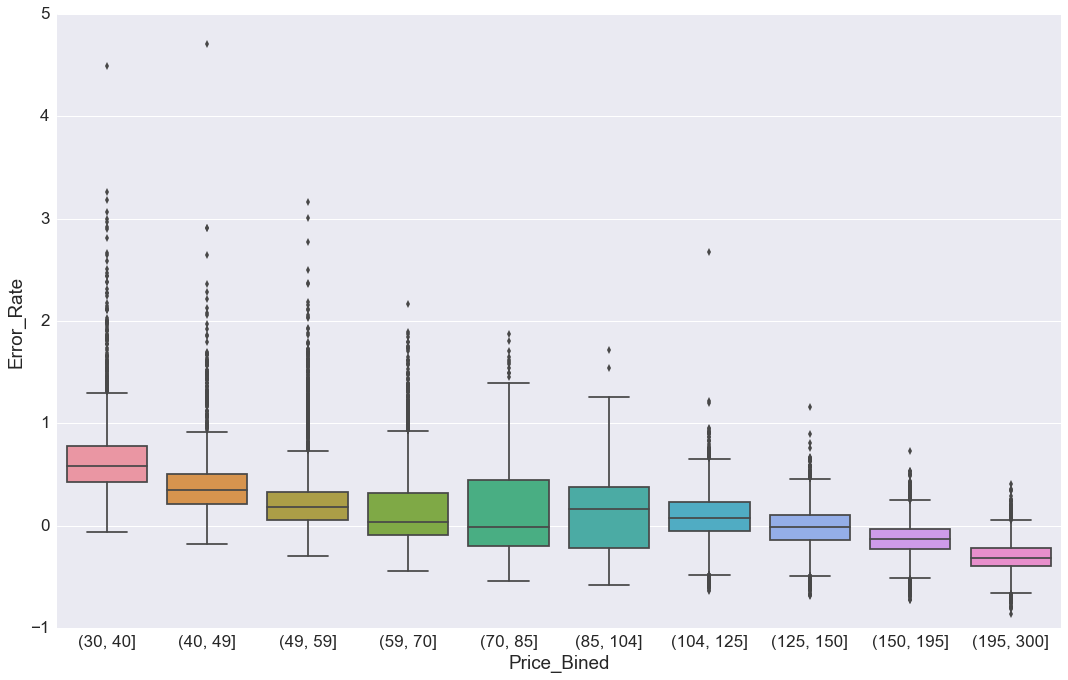

In [265]:
data_error['Price_Bined'] = pd.cut(data_error['Total_Price'], bins = bins_10)
plt.figure(figsize = (18,11))
sns.boxplot(x = data_error['Price_Bined'] , y = data_error['Error_Rate'] )

## Plot Error distribution - XGBoost

In [334]:
data_new_90 = data_new.ix[(data_new['Total_Price'] >=30) & (data_new['Total_Price'] <=300), :-2].copy()
X = data_new_90.ix[:, 1:]
y = data_new_90.ix[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train = X_train.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)

In [203]:
%%time
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.045, learning_rate=0.01, max_depth=20,
                     min_child_weight=1.5, n_estimators=500,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.95)
y_pred_est = est.fit(X_train,y_train).predict(X_train)

CPU times: user 1min 32s, sys: 969 ms, total: 1min 33s
Wall time: 1min 35s


In [207]:
RMSPE(y_train, y_pred_est)

0.13505488438774352

In [204]:
data_error_xgb = pd.concat((X_train, y_train, pd.DataFrame(y_pred_est)), axis = 1)
col = data_error_xgb.columns.tolist()
col[-1] = 'Total_Price_Pred'
data_error_xgb.columns = col
data_error_xgb['Error'] = data_error_xgb['Total_Price_Pred'] - data_error_xgb['Total_Price']
data_error_xgb['Error_Rate'] = data_error_xgb['Error'] / data_error_xgb['Total_Price']

'When Price is low, we tend to over-predict the price; When Price is high, we tend to under-predict the price '

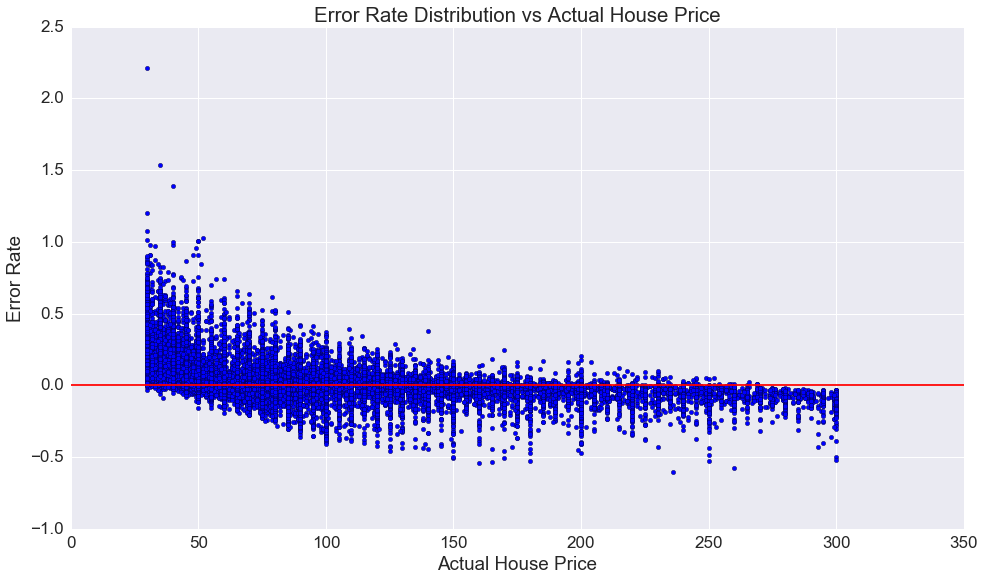

In [205]:
plt.figure(figsize = (16,9))
plt.scatter(data_error_xgb['Total_Price'], data_error_xgb['Error_Rate'])
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')
plt.title('Error Rate Distribution vs Actual House Price')
plt.xlabel('Actual House Price')
plt.ylabel('Error Rate')
'''When Price is low, we tend to over-predict the price; When Price is high, we tend to under-predict the price '''

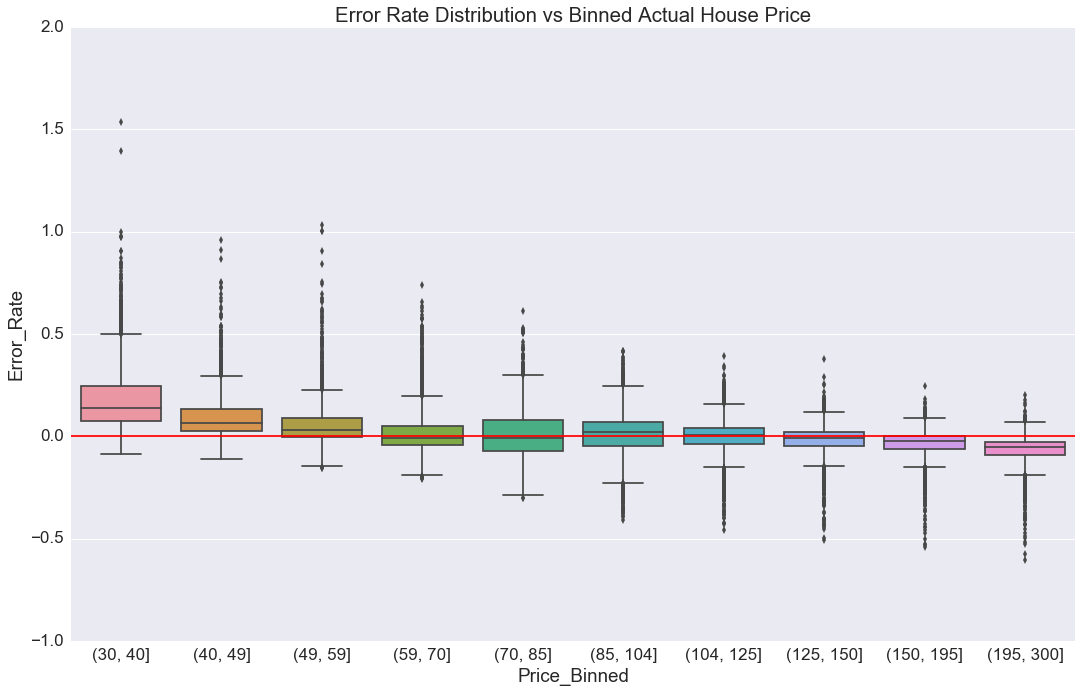

In [206]:
bins_10 = data_error_xgb['Total_Price'].quantile(np.arange(0,1.1,0.1))
data_error_xgb['Price_Binned'] = pd.cut(data_error_xgb['Total_Price'], bins = bins_10)
plt.figure(figsize = (18,11))
sns.boxplot(x = data_error_xgb['Price_Binned'] , y = data_error_xgb['Error_Rate'] )
plt.title('Error Rate Distribution vs Binned Actual House Price')
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')

In [208]:
%%time
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.045, learning_rate=0.01, max_depth=20,
                     min_child_weight=1.5, n_estimators=500,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.95)
y_pred_est = est.fit(X_train,y_train).predict(X_test)

CPU times: user 1min 22s, sys: 1.16 s, total: 1min 23s
Wall time: 1min 27s


In [209]:
RMSPE(y_test, y_pred_est)

0.37163091900302064

In [213]:
data_error_xgb = pd.concat((X_test, y_test, pd.DataFrame(y_pred_est)), axis = 1)
col = data_error_xgb.columns.tolist()
col[-1] = 'Total_Price_Pred'
data_error_xgb.columns = col
data_error_xgb['Error'] = data_error_xgb['Total_Price_Pred'] - data_error_xgb['Total_Price']
data_error_xgb['Error_Rate'] = data_error_xgb['Error'] / data_error_xgb['Total_Price']

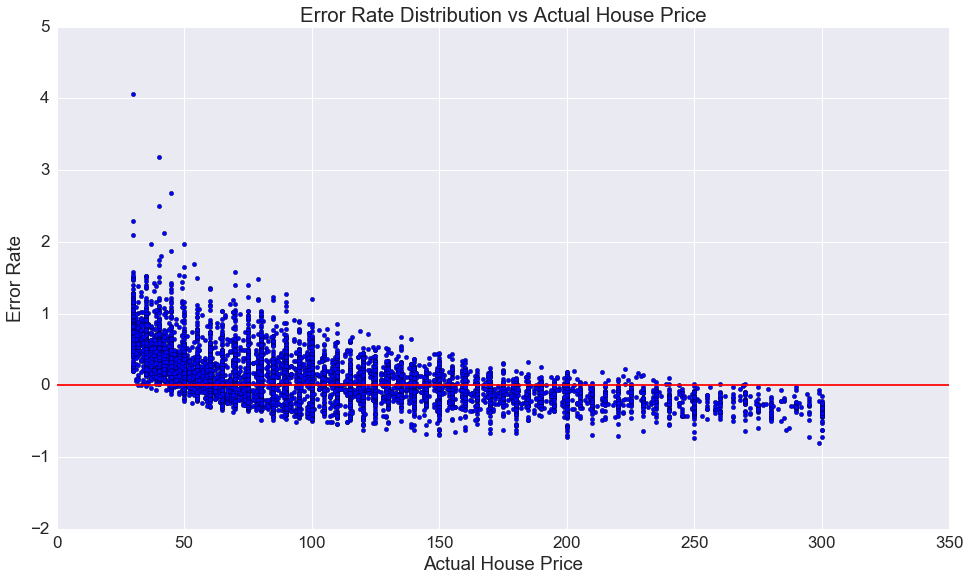

In [214]:
plt.figure(figsize = (16,9))
plt.scatter(data_error_xgb['Total_Price'], data_error_xgb['Error_Rate'])
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')
plt.title('Error Rate Distribution vs Actual House Price')
plt.xlabel('Actual House Price')
plt.ylabel('Error Rate')

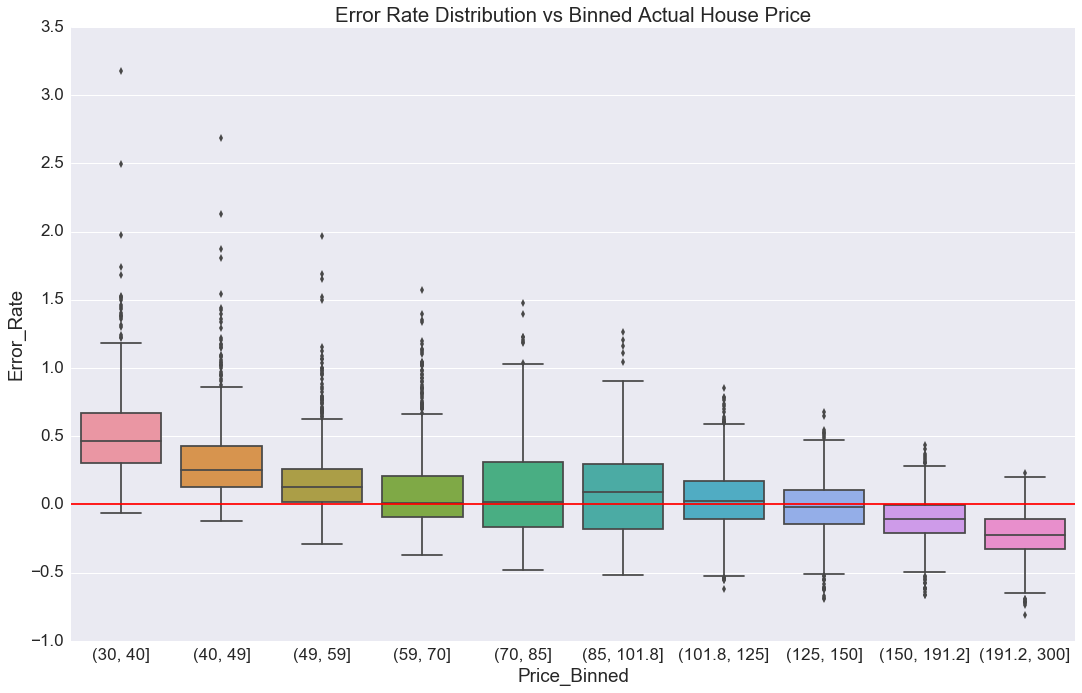

In [215]:
bins_10 = data_error_xgb['Total_Price'].quantile(np.arange(0,1.1,0.1))
data_error_xgb['Price_Binned'] = pd.cut(data_error_xgb['Total_Price'], bins = bins_10)
plt.figure(figsize = (18,11))
sns.boxplot(x = data_error_xgb['Price_Binned'] , y = data_error_xgb['Error_Rate'] )
plt.title('Error Rate Distribution vs Binned Actual House Price')
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')

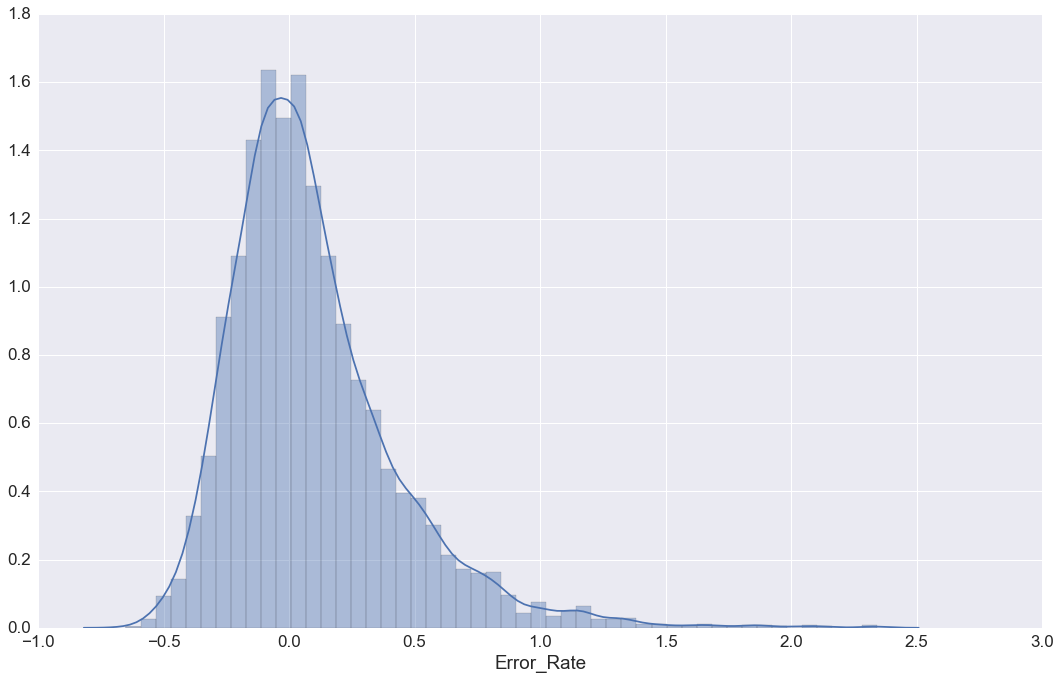

In [285]:
plt.figure(figsize =(18,11) )
sns.distplot(data_error_xgb.ix[data_error_xgb['Error_Rate']<=3,'Error_Rate' ], );

### Try predict by different room_type

In [233]:
col = data_new_90.columns
data_new_90_Entire_Room = data_new_90[data_new_90['room_type_Entire home/apt'] ==1].drop(col[col.str.startswith('room_type')], axis = 1)


In [234]:
data_new_90_Entire_Room.head()

,Total_Price,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,...,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,175.0,6,1.0,3.0,4.0,4,6,87.0,8.0,9.0,...,0,0,0,0,0,0,0,0,0,1
2,82.0,2,1.0,0.0,1.0,5,4,95.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,1
3,145.0,3,1.0,1.0,2.0,1,14,88.0,10.0,8.0,...,0,0,0,0,0,0,0,0,0,1
7,240.0,4,2.0,2.0,2.0,1,1,80.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,1
14,95.0,2,1.0,1.0,1.0,1,6,87.0,10.0,9.0,...,0,0,0,0,0,0,0,0,0,1


In [236]:
from sklearn import model_selection
X_Entire_Room = data_new_90_Entire_Room.ix[:,1:]
y_Entire_Room = data_new_90_Entire_Room.ix[:,0]
x_train_Entire_Room, x_test_Entire_Room, y_train_Entire_Room, y_test_Entire_Room = model_selection.train_test_split(
X_Entire_Room, y_Entire_Room, test_size = 0.2, random_state = 123)

In [237]:
%%time
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.045, learning_rate=0.01, max_depth=20,
                     min_child_weight=1.5, n_estimators=500,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.95)
y_pred_est = est.fit(x_train_Entire_Room,y_train_Entire_Room).predict(x_test_Entire_Room)

CPU times: user 40.6 s, sys: 653 ms, total: 41.2 s
Wall time: 44.9 s


In [238]:
RMSPE(y_test_Entire_Room, y_pred_est)

0.35819143166707884

In [255]:
data_error_xgb = pd.concat((x_test_Entire_Room.reset_index(drop = True),y_test_Entire_Room.reset_index(drop = True), pd.DataFrame(y_pred_est)), axis = 1)
col = data_error_xgb.columns.tolist()
col[-1] = 'Total_Price_Pred'
data_error_xgb.columns = col
data_error_xgb['Error'] = data_error_xgb['Total_Price_Pred'] - data_error_xgb['Total_Price']
data_error_xgb['Error_Rate'] = data_error_xgb['Error'] / data_error_xgb['Total_Price']

In [259]:
data_error_xgb.sort_values(by = 'Error_Rate', ascending = False)[:1000].to_csv('top_error.csv')

In [260]:
data_error_xgb.sort_values(by = 'Error_Rate', ascending = False)[:10]

,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,Total_Price,Total_Price_Pred,Error,Error_Rate,Price_Binned
604,4,1.5,2.0,2.0,1,1,100.0,10.0,10.0,10.0,...,0,0,0,0,1,32.0,142.723068,110.723068,3.460096,"(30, 77.3]"
369,4,2.0,2.0,2.0,30,33,94.0,10.0,9.0,10.0,...,0,0,0,0,1,45.0,188.418350,143.418350,3.187074,"(30, 77.3]"
2930,8,8.0,8.0,8.0,7,0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,47.0,157.036514,110.036514,2.341202,"(30, 77.3]"
2228,2,2.0,5.0,5.0,1,0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,42.0,139.422562,97.422562,2.319585,"(30, 77.3]"
280,4,1.0,2.0,2.0,3,1,100.0,10.0,10.0,10.0,...,0,0,0,0,1,40.0,125.866806,85.866806,2.146670,"(30, 77.3]"
3072,5,1.0,2.0,2.0,4,4,90.0,10.0,10.0,10.0,...,0,0,0,0,1,40.0,123.182800,83.182800,2.079570,"(30, 77.3]"
1898,3,2.0,3.0,3.0,1,0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,40.0,122.514091,82.514091,2.062852,"(30, 77.3]"
3305,1,1.0,1.0,1.0,1,2,60.0,8.0,10.0,10.0,...,0,0,0,0,1,30.0,89.397079,59.397079,1.979903,NaN
3264,1,1.0,1.0,1.0,2,5,100.0,9.0,10.0,10.0,...,0,0,0,0,1,30.0,86.483116,56.483116,1.882771,NaN
2107,11,2.0,2.0,7.0,2,1,100.0,8.0,10.0,10.0,...,0,0,0,0,1,69.0,197.738525,128.738525,1.865776,"(30, 77.3]"


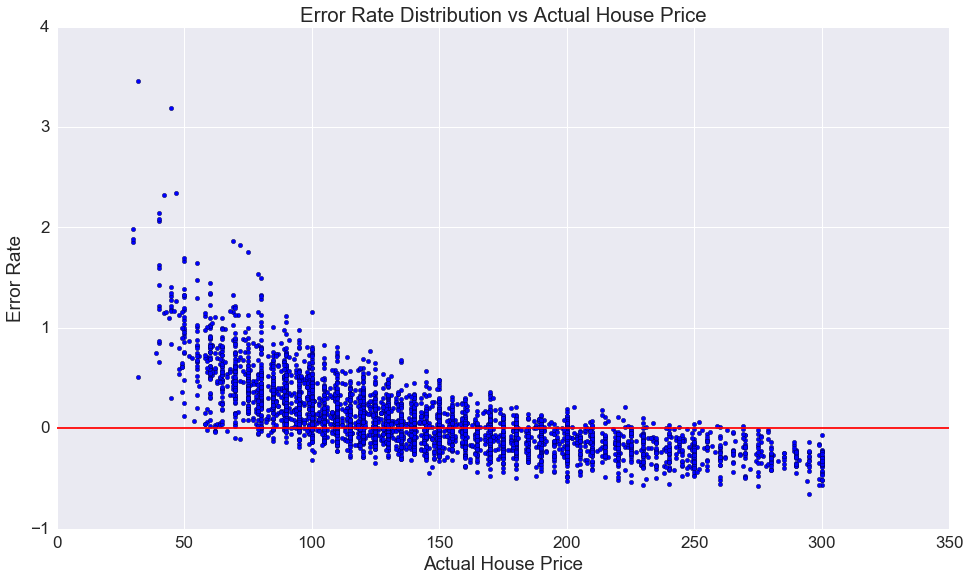

In [256]:
plt.figure(figsize = (16,9))
plt.scatter(data_error_xgb['Total_Price'], data_error_xgb['Error_Rate'])
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')
plt.title('Error Rate Distribution vs Actual House Price')
plt.xlabel('Actual House Price')
plt.ylabel('Error Rate')

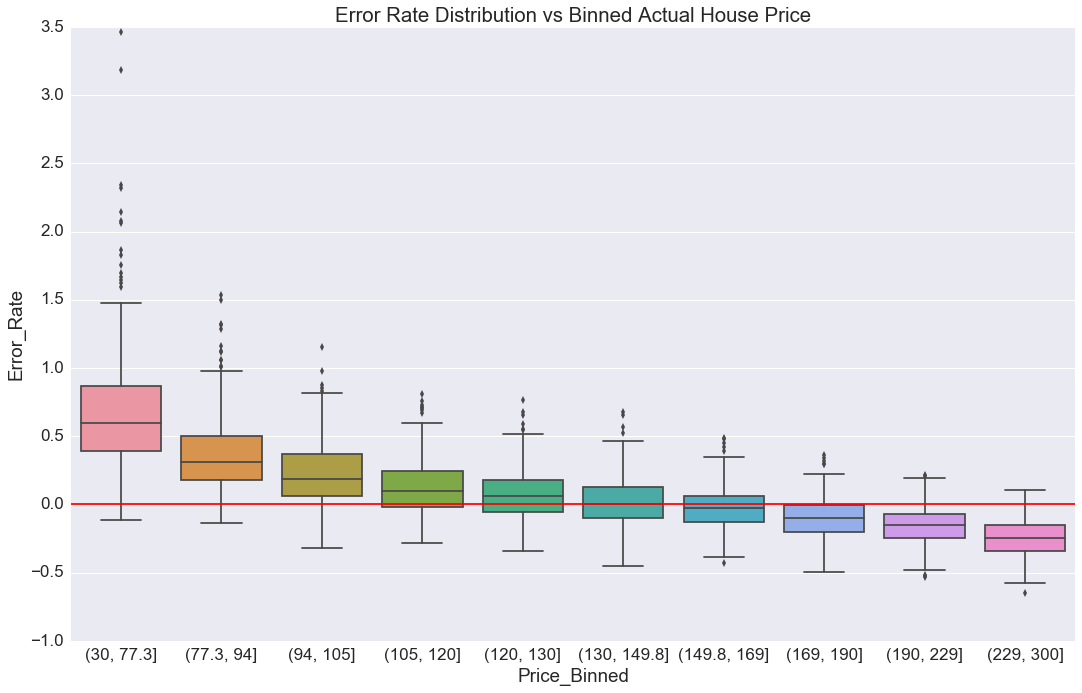

In [257]:
bins_10 = data_error_xgb['Total_Price'].quantile(np.arange(0,1.1,0.1))
data_error_xgb['Price_Binned'] = pd.cut(data_error_xgb['Total_Price'], bins = bins_10)
plt.figure(figsize = (18,11))
sns.boxplot(x = data_error_xgb['Price_Binned'] , y = data_error_xgb['Error_Rate'] )
plt.title('Error Rate Distribution vs Binned Actual House Price')
plt.axhline(y=0, xmin=0, xmax=350,  c = 'r')

In [245]:
x_train_Entire_Room.shape

(15935, 68)

### Try custom objective function 

In [14]:
import xgboost as xgb

In [28]:
def custom_obj(preds, y_test):
    grad =  2*(preds - y_test) / y_test**2
    hess = 2/np.ones(len(preds)) * y_test**2
    return grad, hess

In [29]:
%%time
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.045, learning_rate=0.1, max_depth=20,
                     min_child_weight=1.5, n_estimators=50,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.95
                    , objective  = custom_obj)
y_pred_est = est.fit(X_train,y_train).predict(X_test)

CPU times: user 3.21 s, sys: 89.5 ms, total: 3.3 s
Wall time: 3.37 s


In [30]:
RMSPE( y_test, y_pred_est)

3.0305248976514703

In [31]:
%%time
est=xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.045, learning_rate=0.01, max_depth=20,
                     min_child_weight=1.5, n_estimators=500,  
                     reg_alpha=0.65, reg_lambda=0.45, subsample=0.95
                    , objective  = custom_obj)
y_pred_est = est.fit(X_train,y_train).predict(X_test)

CPU times: user 1min 31s, sys: 655 ms, total: 1min 32s
Wall time: 1min 33s


In [32]:
RMSPE( y_test, y_pred_est)

1.1856012539395984

In [33]:
%%time
est=xgb.XGBRegressor(colsample_bytree=0.9, gamma=0.3, learning_rate=0.01, max_depth=10,
                     min_child_weight=4, n_estimators=1000,  
                     reg_alpha=0.65, reg_lambda=5, subsample=0.9
                    , objective  = custom_obj)
y_pred_est = est.fit(X_train,y_train).predict(X_test)

CPU times: user 2min 33s, sys: 1.26 s, total: 2min 34s
Wall time: 2min 36s


In [34]:
RMSPE( y_test, y_pred_est)

1.1747399494432424

In [272]:
from sklearn.metrics import mean_squared_error

In [273]:
mean_squared_error(y_test, y_pred_est)

102942.37162870541

In [280]:
y_test.describe()

count    7709.000000
mean      102.353224
std        61.356478
min        30.000000
25%        53.000000
50%        85.000000
75%       139.000000
max       300.000000
Name: Total_Price, dtype: float64

In [281]:
y_train.describe()

count    30832.000000
mean       102.958712
std         61.911983
min         30.000000
25%         53.000000
50%         85.000000
75%        139.000000
max        300.000000
Name: Total_Price, dtype: float64